<a href="https://colab.research.google.com/github/chahn85/UNOS_Synthetic/blob/main/Syn_MELD_RiskScore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required packages
!pip install numpy pandas matplotlib seaborn scikit-learn torch lifelines tqdm joblib

# Optional: for better Jupyter widgets support
!pip install ipywidgets

# If using Google Colab, you might need to restart the runtime after installation
# for some packages to work properly

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 10.3 MB/s eta 0:00:

In [3]:
# Try to import calibration_curve from its new location first
try:
    from sklearn.calibration import calibration_curve
except ImportError:
    # Fall back to old location for older scikit-learn versions
    try:
        from sklearn.metrics import calibration_curve
    except ImportError:
        # If not available in either location, define our own implementation
        def calibration_curve(y_true, y_prob, n_bins=5, strategy='uniform'):
            """Custom implementation of calibration curve.

            Parameters
            ----------
            y_true : array-like
                True binary labels.
            y_prob : array-like
                Probabilities of the positive class.
            n_bins : int
                Number of bins to use.
            strategy : {'uniform', 'quantile'}
                Strategy used to define the widths of the bins.

            Returns
            -------
            prob_true : array
                The true probability in each bin (fraction of positives).
            prob_pred : array
                The mean predicted probability in each bin.
            """
            import numpy as np

            y_true = np.array(y_true)
            y_prob = np.array(y_prob)

            # Sort by predicted probability
            idx_sorted = np.argsort(y_prob)
            y_true = y_true[idx_sorted]
            y_prob = y_prob[idx_sorted]

            if strategy == 'quantile':
                # Quantile binning (equal number of samples in each bin)
                quantiles = np.linspace(0, 1, n_bins + 1)
                bins = np.percentile(y_prob, quantiles * 100)
                # Fix for duplicates in bins
                bins = np.unique(bins)
            else:
                # Uniform binning (equal bin widths)
                bins = np.linspace(0, 1, n_bins + 1)

            bin_indices = np.digitize(y_prob, bins[1:])

            bin_sums = np.bincount(bin_indices, weights=y_true, minlength=len(bins)-1)
            bin_counts = np.bincount(bin_indices, minlength=len(bins)-1)
            nonzero = bin_counts != 0

            prob_true = np.zeros(len(bins)-1)
            prob_true[nonzero] = bin_sums[nonzero] / bin_counts[nonzero]

            prob_pred = np.zeros(len(bins)-1)
            for i in range(len(bins)-1):
                bin_idx = bin_indices == i
                if np.any(bin_idx):
                    prob_pred[i] = np.mean(y_prob[bin_idx])
                else:
                    prob_pred[i] = (bins[i] + bins[i+1]) / 2

            return prob_true, prob_pred

In [5]:
# Update Matplotlib style setting
import matplotlib.pyplot as plt
import seaborn as sns

# Check if we're using a newer version of matplotlib/seaborn
try:
    plt.style.use('seaborn-whitegrid')  # older versions
except:
    try:
        plt.style.use('seaborn-v0_8-whitegrid')  # newer versions
    except:
        # If both fail, use a basic style that works everywhere
        plt.style.use('ggplot')

# Set Seaborn style directly as a fallback
sns.set_style("whitegrid")
sns.set_palette('Set1')

In [7]:
"""Liver Survival Prediction with Exponential Calibration

This notebook:
1. Loads the pre-trained model, embeddings, and synthetic data
2. Tests the model vs MELD 3.0 on the UNOS cohort
3. Creates an exponential transformation for a 1-100 risk score
4. Provides the final formula for implementation
"""

import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import brier_score_loss, roc_auc_score
# calibration_curve is imported or defined abovefrom lifelines.utils import concordance_index
from lifelines import KaplanMeierFitter
from tqdm.auto import tqdm
from joblib import Parallel, delayed

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set1')

# PART 1: LOAD MODEL, EMBEDDINGS, AND SYNTHETIC DATA

# Define the directory where your model and data are saved
save_dir = '/content/drive/MyDrive/SyntheticData/saved_models'

# Define the MetricNet class to load the model
class MetricNet(nn.Module):
    def __init__(self, input_dim, embedding_dim=64, hidden_dims=[256, 512, 256, 128]):
        super(MetricNet, self).__init__()
        layers = []
        current_dim = input_dim

        for hd in hidden_dims:
            layers.extend([
                nn.Linear(current_dim, hd),
                nn.BatchNorm1d(hd),
                nn.ReLU(),
                nn.Dropout(0.2)
            ])
            current_dim = hd
        layers.append(nn.Linear(current_dim, embedding_dim))

        self.net = nn.Sequential(*layers)
        self.transform = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim, bias=False),
            nn.BatchNorm1d(embedding_dim)
        )

    def forward(self, x):
        emb = self.net(x)
        transformed = self.transform(emb)
        normalized = F.normalize(transformed, p=2, dim=1)
        return normalized

# Load model parameters
with open(os.path.join(save_dir, 'model_params.pkl'), 'rb') as f:
    params = pickle.load(f)

numeric_features = params['numeric_features']
categorical_features = params['categorical_features']
embedding_dim = params['embedding_dim']
input_dim = params['input_dim']
device = torch.device('cpu')  # We'll use CPU for simplicity

print("Model parameters loaded:")
print(f"Numeric features: {numeric_features}")
print(f"Categorical features: {categorical_features}")
print(f"Embedding dimension: {embedding_dim}")
print(f"Input dimension: {input_dim}")

# Load scaler
with open(os.path.join(save_dir, 'feature_scaler.pkl'), 'rb') as f:
    scaler = pickle.load(f)

# Load categorical feature names for encoding
with open(os.path.join(save_dir, 'cat_feature_names.pkl'), 'rb') as f:
    cat_feature_names = pickle.load(f)

print(f"Loaded feature scaler and {len(cat_feature_names)} categorical feature encodings")

# Load synthetic embeddings
syn_embeddings = np.load(os.path.join(save_dir, 'synthetic_embeddings.npy'))

# Load synthetic reference data
syn_reference = pd.read_csv(os.path.join(save_dir, 'synthetic_reference_data.csv'), index_col=0)

print(f"Loaded synthetic embeddings with shape: {syn_embeddings.shape}")
print(f"Loaded synthetic reference data with {len(syn_reference)} samples")

# Initialize model
metric_model = MetricNet(input_dim, embedding_dim=embedding_dim)
metric_model.eval()

# Load model state
model_path = os.path.join(save_dir, 'metric_model.pth')
state_dict = torch.load(model_path, map_location=device)
metric_model.load_state_dict(state_dict)
print("Model loaded successfully!")

Model parameters loaded:
Numeric features: ['Na', 'Cr', 'INR', 'Bili', 'Albumin']
Categorical features: ['Gender', 'Dialysis']
Embedding dimension: 64
Input dimension: 9
Loaded feature scaler and 4 categorical feature encodings
Loaded synthetic embeddings with shape: (10000000, 64)
Loaded synthetic reference data with 10000000 samples


<ipython-input-7-90df94d61b1f>:106: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


Model loaded successfully!


In [9]:
# PART 2: TEST MODEL VS MELD 3.0 ON UNOS COHORT

# Load the UNOS cohort
df = pd.read_csv('/content/drive/MyDrive/SyntheticData/UNOS_Cohort.csv')
print(f"Loaded UNOS cohort with {len(df)} patients")

# Create a random sample of 30% for testing
sample_size = 0.3
np.random.seed(42)  # For reproducibility
test_df = df.sample(frac=sample_size, random_state=42)
print(f"Test set: {len(test_df)} patients ({sample_size*100:.0f}% of original)")

# Calculate MELD 3.0
def calculate_meld3(row):
    # Determine if female (1 if F, 0 otherwise)
    female = 1 if row['Gender'] == 'F' else 0

    # Apply lower/upper bounds as needed
    bilirubin = max(1.0, row['Bili'])
    sodium = min(137, max(125, row['Na']))
    inr = max(1.0, row['INR'])
    creatinine = min(3.0, max(1.0, row['Cr']))
    albumin = min(3.5, max(1.5, row['Albumin']))

    # Calculate components
    female_component = 1.33 * female
    bilirubin_component = 4.56 * np.log(bilirubin)
    sodium_component = 0.82 * (137 - sodium)
    interaction1 = -0.24 * (137 - sodium) * np.log(bilirubin)
    inr_component = 9.09 * np.log(inr)
    creatinine_component = 11.14 * np.log(creatinine)
    albumin_component = 1.85 * (3.5 - albumin)
    interaction2 = -1.83 * (3.5 - albumin) * np.log(creatinine)
    constant = 6

    # Sum all components to get the MELD3 score and round it
    meld3 = (female_component + bilirubin_component + sodium_component +
             interaction1 + inr_component + creatinine_component +
             albumin_component + interaction2 + constant)
    return round(meld3)

# Calculate MELD3 for the test set
test_df['meld3'] = test_df.apply(calculate_meld3, axis=1)

# Process the test data for embedding generation
# Handle missing values in numeric features
test_df[numeric_features] = test_df[numeric_features].fillna(test_df[numeric_features].median())

# Process numeric features
test_numeric = test_df[numeric_features].astype(float)
test_numeric_scaled = scaler.transform(test_numeric)

# Process categorical features
test_cat = test_df[categorical_features].astype(str)
test_cat_encoded = pd.get_dummies(test_cat, drop_first=False)
test_cat_encoded = test_cat_encoded.reindex(columns=cat_feature_names, fill_value=0)

# Combine features
test_features = np.hstack([test_numeric_scaled, test_cat_encoded.values]).astype(np.float32)
print(f"Test feature matrix shape: {test_features.shape}")

# Generate embeddings for test data in batches
print("Generating embeddings for test data...")
batch_size = 128
test_embeddings = []

with torch.no_grad():
    for i in range(0, len(test_features), batch_size):
        batch = torch.tensor(test_features[i:i+batch_size], dtype=torch.float32)
        emb = metric_model(batch).numpy()
        test_embeddings.append(emb)

test_embeddings = np.vstack(test_embeddings)
print(f"Test embeddings shape: {test_embeddings.shape}")


Loaded UNOS cohort with 48774 patients
Test set: 14632 patients (30% of original)
Test feature matrix shape: (14632, 9)
Generating embeddings for test data...
Test embeddings shape: (14632, 64)


In [10]:
# Find nearest neighbors for test patients with maximum k value
max_k = 1000
print(f"Finding nearest neighbors for test patients (up to k={max_k})...")
nbrs = NearestNeighbors(n_neighbors=max_k, algorithm='auto')
nbrs.fit(syn_embeddings)
distances, indices = nbrs.kneighbors(test_embeddings)

Finding nearest neighbors for test patients (up to k=1000)...


In [11]:
# Fast KM median implementation for efficient computation
def fast_km_median(times, events):
    """
    Compute a Kaplan-Meier median survival time from a small sample.
    Assumes times and events are 1D NumPy arrays of length n.
    """
    # Sort times and events by times.
    order = np.argsort(times)
    times = times[order]
    events = events[order]

    n = len(times)
    survival = 1.0
    median_time = None
    at_risk = n

    # Loop over each unique time.
    for t, e in zip(times, events):
        if at_risk > 0:
            survival *= (1 - e / at_risk)
        if survival <= 0.5:
            median_time = t
            break
        at_risk -= 1

    # If survival never drops below 0.5, fallback to max observed time.
    if median_time is None:
        median_time = times[-1]

    return median_time

# Function to compute predicted TTE using KM estimator
def compute_predicted_tte_km(idx, indices, k):
    neighbor_idxs = indices[idx, :k]
    neighbor_tte = syn_reference.iloc[neighbor_idxs]['tte'].values
    neighbor_outcome = syn_reference.iloc[neighbor_idxs]['outcome'].values
    neighbor_event = (neighbor_outcome == 0).astype(int)  # 1 if death (outcome=0), else 0

    # Use KM estimator to find median survival
    return fast_km_median(neighbor_tte, neighbor_event)

In [12]:
# Define neighbor sizes to test
neighbor_sizes = [100, 200, 300, 500, 750, 1000]

# Compute predicted TTE for each neighbor size
print("Computing predicted TTE for multiple neighbor sizes...")
for k in neighbor_sizes:
    # Column name for this k value
    col_name = f'predicted_tte_k{k}'

    # Compute TTE for all patients with this k value
    predicted_tte = []
    for i in range(len(test_df)):
        tte = compute_predicted_tte_km(i, indices, k)
        predicted_tte.append(tte)
        if i % 100 == 0:
            print(f"Processing k={k}: {i}/{len(test_df)} patients", end="\r")

    # Add to dataframe
    test_df[col_name] = predicted_tte
    print(f"\nk={k} - Predicted TTE: Mean={np.mean(predicted_tte):.1f}, Median={np.median(predicted_tte):.1f}")

Computing predicted TTE for multiple neighbor sizes...
Processing k=100: 14600/14632 patients
k=100 - Predicted TTE: Mean=747.6, Median=427.2
Processing k=200: 14600/14632 patients
k=200 - Predicted TTE: Mean=745.2, Median=436.9
Processing k=300: 14600/14632 patients
k=300 - Predicted TTE: Mean=744.1, Median=442.7
Processing k=500: 14600/14632 patients
k=500 - Predicted TTE: Mean=741.9, Median=446.1
Processing k=750: 14600/14632 patients
k=750 - Predicted TTE: Mean=740.3, Median=450.4

k=1000 - Predicted TTE: Mean=739.8, Median=452.1



Concordance Index (C-index) comparison with proper censoring:
Time 7 days: 171 events out of 14632 patients (0.0117)
  MELD3 c-index (corrected): 0.8798
  k=100: TTE range = 3.8 to 2981.9
  k=100 c-index (corrected): 0.9026
  k=200: TTE range = 4.0 to 2981.9
  k=200 c-index (corrected): 0.9028
  k=300: TTE range = 4.0 to 2981.6
  k=300 c-index (corrected): 0.9019
  k=500: TTE range = 4.0 to 2981.9
  k=500 c-index (corrected): 0.9020
  k=750: TTE range = 4.0 to 2981.9
  k=750 c-index (corrected): 0.9016
  k=1000: TTE range = 4.0 to 2981.6
  k=1000 c-index (corrected): 0.9018
Time 14 days: 318 events out of 14632 patients (0.0217)
  MELD3 c-index (corrected): 0.8863
  k=100: TTE range = 3.8 to 2981.9
  k=100 c-index (corrected): 0.9033
  k=200: TTE range = 4.0 to 2981.9


<ipython-input-17-d466be59dc5e>:60: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  c_indices = pd.concat([c_indices, row_df], ignore_index=True)


  k=200 c-index (corrected): 0.9041
  k=300: TTE range = 4.0 to 2981.6
  k=300 c-index (corrected): 0.9038
  k=500: TTE range = 4.0 to 2981.9
  k=500 c-index (corrected): 0.9040
  k=750: TTE range = 4.0 to 2981.9
  k=750 c-index (corrected): 0.9037
  k=1000: TTE range = 4.0 to 2981.6
  k=1000 c-index (corrected): 0.9037
Time 30 days: 498 events out of 14632 patients (0.0340)
  MELD3 c-index (corrected): 0.8772
  k=100: TTE range = 3.8 to 2981.9
  k=100 c-index (corrected): 0.8934
  k=200: TTE range = 4.0 to 2981.9
  k=200 c-index (corrected): 0.8944
  k=300: TTE range = 4.0 to 2981.6
  k=300 c-index (corrected): 0.8948
  k=500: TTE range = 4.0 to 2981.9
  k=500 c-index (corrected): 0.8948
  k=750: TTE range = 4.0 to 2981.9
  k=750 c-index (corrected): 0.8946
  k=1000: TTE range = 4.0 to 2981.6
  k=1000 c-index (corrected): 0.8947
Time 90 days: 837 events out of 14632 patients (0.0572)
  MELD3 c-index (corrected): 0.8411
  k=100: TTE range = 3.8 to 2981.9
  k=100 c-index (corrected): 0.

<ipython-input-17-d466be59dc5e>:95: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(time_points, c_indices['MELD3'], 'o-', linestyle='--', color='black', linewidth=2, label='MELD3')


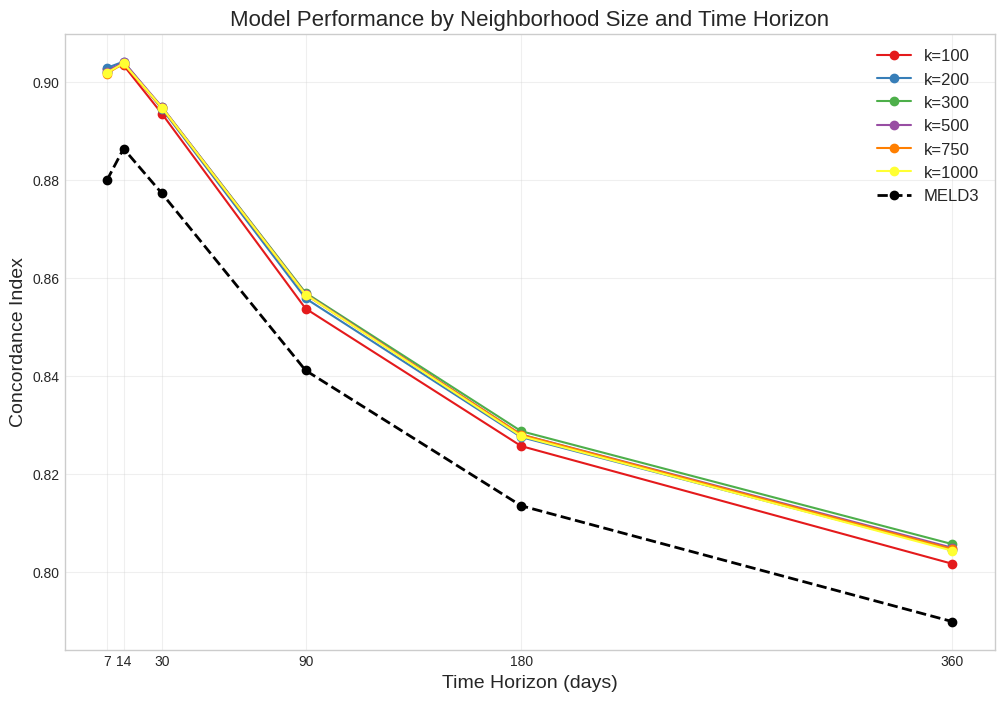


Best overall k value based on 90-day performance: k=300


In [17]:
from lifelines.utils import concordance_index

# Calculate concordance index for different time horizons and k values
print("\nConcordance Index (C-index) comparison with proper censoring:")
c_indices = pd.DataFrame(columns=['Time', 'MELD3'] + [f'k={k}' for k in neighbor_sizes])

for t in time_points:
    # Create subset for patients at risk at time t
    at_risk = test_df.copy()

    # Handle times and events properly:
    # First, cap all times at time t
    at_risk['time'] = np.minimum(at_risk['tte'], t)

    # Mark events: only death (outcome=0) counts as an event
    at_risk['event'] = ((at_risk['outcome'] == 0) & (at_risk['tte'] <= t)).astype(int)

    print(f"Time {t} days: {at_risk['event'].sum()} events out of {len(at_risk)} patients ({at_risk['event'].mean():.4f})")

    # CRITICAL FIX: For concordance index, use:
    # - Higher MELD = higher risk, so use POSITIVE meld score
    # - Higher TTE = lower risk, so use POSITIVE predicted TTE (not negative)

    # Calculate c-index for MELD3 (higher score = higher risk)
    # Note: concordance_index expects higher values to indicate LOWER risk by default
    # So we need to flip the sign to match convention
    if at_risk['event'].sum() > 0:
        c_meld = 1 - concordance_index(at_risk['time'], at_risk['meld3'], at_risk['event'])
        print(f"  MELD3 c-index (corrected): {c_meld:.4f}")
    else:
        c_meld = np.nan

    # Calculate c-index for each k value
    c_values = [c_meld]
    for k in neighbor_sizes:
        tte_col = f'predicted_tte_k{k}'

        # Check TTE range
        tte_min, tte_max = at_risk[tte_col].min(), at_risk[tte_col].max()
        print(f"  k={k}: TTE range = {tte_min:.1f} to {tte_max:.1f}")

        # Calculate c-index (higher TTE = lower risk, which matches default)
        if at_risk['event'].sum() > 0:
            # We don't need to negate since higher TTE already means lower risk
            c_k = concordance_index(at_risk['time'], at_risk[tte_col], at_risk['event'])
            print(f"  k={k} c-index (corrected): {c_k:.4f}")
        else:
            c_k = np.nan

        c_values.append(c_k)

    # Add to results
    row_dict = {'Time': f"{t} days"}
    row_dict['MELD3'] = c_meld
    for i, k in enumerate(neighbor_sizes):
        row_dict[f'k={k}'] = c_values[i+1]

    # Create a new DataFrame for this row and concatenate
    row_df = pd.DataFrame([row_dict])
    c_indices = pd.concat([c_indices, row_df], ignore_index=True)

print(c_indices.round(4))

# Rest of code remains the same...

# Find the best k value for each time point
best_k_values = {}
for t in time_points:
    row = c_indices[c_indices['Time'] == f"{t} days"]
    if len(row) == 0:
        continue

    # Find column with highest c-index (excluding Time and MELD3)
    k_columns = [f'k={k}' for k in neighbor_sizes]
    best_col = k_columns[np.argmax(row[k_columns].values[0])]
    best_k = int(best_col.replace('k=', ''))
    best_value = row[best_col].values[0]
    meld_value = row['MELD3'].values[0]

    best_k_values[t] = {
        'k': best_k,
        'c_index': best_value,
        'meld3_c_index': meld_value,
        'improvement': best_value - meld_value
    }

print("\nBest k values by time point:")
for t, info in best_k_values.items():
    print(f"{t} days: k={info['k']} (c-index={info['c_index']:.4f}, improvement over MELD3: {info['improvement']:.4f})")

# Visualize c-index by time and k value
plt.figure(figsize=(12, 8))
for k in neighbor_sizes:
    plt.plot(time_points, c_indices[f'k={k}'], 'o-', label=f'k={k}')
plt.plot(time_points, c_indices['MELD3'], 'o-', linestyle='--', color='black', linewidth=2, label='MELD3')
plt.xlabel('Time Horizon (days)', fontsize=14)
plt.ylabel('Concordance Index', fontsize=14)
plt.title('Model Performance by Neighborhood Size and Time Horizon', fontsize=16)
plt.xticks(time_points)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.savefig('concordance_by_time_k.png', dpi=300, bbox_inches='tight')
plt.show()

# Determine the best k value overall based on 90-day performance
t90_row = c_indices[c_indices['Time'] == "90 days"]
k_columns = [f'k={k}' for k in neighbor_sizes]
best_k_90d = int(k_columns[np.argmax(t90_row[k_columns].values[0])].replace('k=', ''))

print(f"\nBest overall k value based on 90-day performance: k={best_k_90d}")
best_k = best_k_90d  # We'll use this for further analysis


Best lambda: 30.00

Reference Table (sample):
   TTE_Days  Probability  Risk_Score
0         0     1.000000         100
1         1     1.000000         100
2         2     1.000000         100
3         3     0.974386          97
4         4     0.972973          97
5         5     0.972973          97
6         6     0.972973          97
7         7     0.972973          97
8         8     0.972973          97
9         9     0.905660          91

Example Risk Score Calculations:
TTE: 7 days → Risk Score: 97
TTE: 14 days → Risk Score: 91
TTE: 30 days → Risk Score: 79
TTE: 60 days → Risk Score: 54
TTE: 90 days → Risk Score: 19
TTE: 180 days → Risk Score: 1
TTE: 365 days → Risk Score: 1


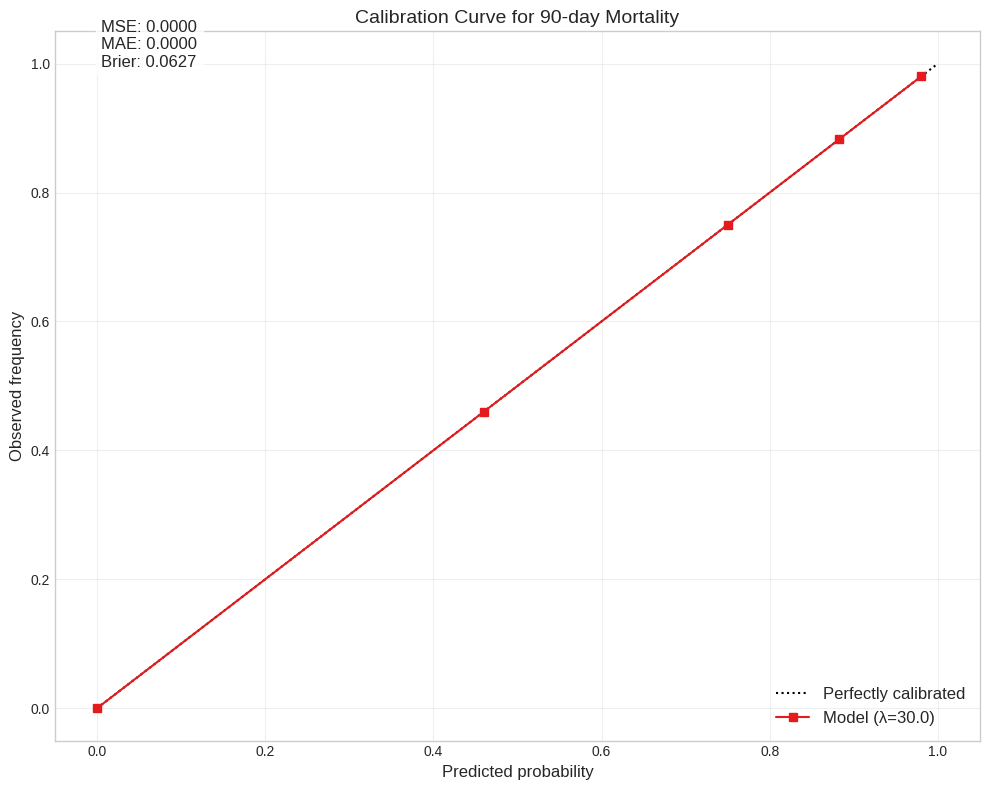

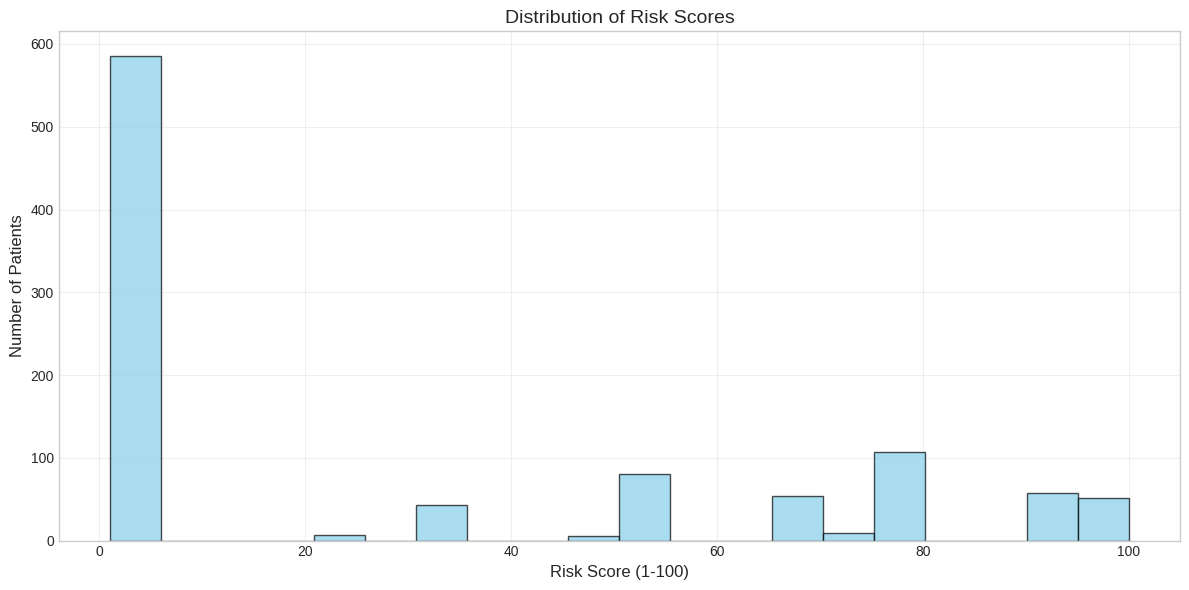

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve

def fit_exponential_transformation(tte_values, outcomes, event_time=90, lambda_values=None):
    """
    Fit exponential transformation to convert TTE to probability of death within event_time days.

    Parameters:
    -----------
    tte_values : array-like
        Time-to-event values in days
    outcomes : array-like
        Array of outcome indicators:
        - 0: Death
        - 1: Censored (not death)
        - 2: Transplant (competing risk)
    event_time : int, default=90
        Time horizon in days (e.g., 90 for 90-day mortality)
    lambda_values : array-like, optional
        Range of lambda values to test. If None, uses default range.

    Returns:
    --------
    best_lambda : float
        Optimal lambda value for the exponential transformation
    brier_scores : dict
        Dictionary of Brier scores for each lambda
    """
    # Create 90-day mortality indicator (with transplant censoring)
    death_by_event_time = ((outcomes == 0) & (tte_values <= event_time)).astype(int)

    # Exclude transplant patients from calibration
    calibration_mask = (outcomes != 2) | (tte_values > event_time)

    # Default lambda range if not provided
    if lambda_values is None:
        lambda_values = np.linspace(30, 400, 20)

    # Calculate Brier score for each lambda value
    brier_scores = {}
    isotonic_regs = {}

    for lambda_val in lambda_values:
        # Apply exponential transformation to get probability
        probs = np.exp(-np.array(tte_values) / lambda_val)

        # Fit isotonic regression for calibration on subset
        iso_reg = IsotonicRegression(out_of_bounds='clip')
        iso_reg.fit(
            probs[calibration_mask],
            death_by_event_time[calibration_mask]
        )

        # Apply calibration to all patients
        calibrated_probs = iso_reg.predict(probs)

        # Calculate Brier score on the same subset used for calibration
        brier = brier_score_loss(
            death_by_event_time[calibration_mask],
            calibrated_probs[calibration_mask]
        )

        brier_scores[lambda_val] = brier
        isotonic_regs[lambda_val] = iso_reg

    # Find best lambda (lowest Brier score)
    best_lambda = min(brier_scores, key=brier_scores.get)
    best_iso_reg = isotonic_regs[best_lambda]

    return best_lambda, brier_scores, best_iso_reg

def tte_to_risk_score(tte, lambda_val, iso_reg=None):
    """
    Convert time-to-event (TTE) to a 1-100 risk score.

    Parameters:
    -----------
    tte : float or array-like
        Time-to-event in days
    lambda_val : float
        Lambda parameter for exponential transformation
    iso_reg : IsotonicRegression, optional
        Isotonic regression model for calibration. If None, no calibration is applied.

    Returns:
    --------
    risk_score : int or array-like
        Risk score from 1-100, with 100 being highest risk
    """
    # Convert to numpy array if not already
    tte_array = np.atleast_1d(tte)

    # Apply exponential transformation
    probs = np.exp(-tte_array / lambda_val)

    # Apply isotonic calibration if provided
    if iso_reg is not None:
        probs = iso_reg.predict(probs)

    # Convert to 1-100 scale
    scores = np.round(1 + 99 * probs).astype(int)

    # Ensure in range 1-100
    scores = np.clip(scores, 1, 100)

    # If input was a scalar, return a scalar
    if np.isscalar(tte):
        return scores[0]
    else:
        return scores

def create_risk_score_reference_table(lambda_val, iso_reg=None):
    """
    Create a reference table for TTE to risk score mapping.

    Parameters:
    -----------
    lambda_val : float
        Lambda parameter for exponential transformation
    iso_reg : IsotonicRegression, optional
        Isotonic regression model for calibration

    Returns:
    --------
    reference_df : pandas.DataFrame
        Reference table with TTE values and corresponding risk scores
    """
    # Create range of TTE values
    tte_values = np.concatenate([
        np.arange(0, 10, 1),     # 1-day intervals for first 10 days
        np.arange(10, 30, 2),    # 2-day intervals from 10-30 days
        np.arange(30, 90, 5),    # 5-day intervals from 30-90 days
        np.arange(90, 180, 15),  # 15-day intervals from 90-180 days
        np.arange(180, 365, 30), # 30-day intervals from 180-365 days
        np.arange(365, 731, 90), # 90-day intervals from 1-2 years
        np.arange(731, 1826, 365) # 1-year intervals beyond 2 years
    ])

    # Calculate probabilities and risk scores
    probs = np.exp(-tte_values / lambda_val)
    if iso_reg is not None:
        calibrated_probs = iso_reg.predict(probs)
    else:
        calibrated_probs = probs

    risk_scores = np.round(1 + 99 * calibrated_probs).astype(int)
    risk_scores = np.clip(risk_scores, 1, 100)

    # Create DataFrame
    reference_df = pd.DataFrame({
        'TTE_Days': tte_values,
        'Probability': calibrated_probs,
        'Risk_Score': risk_scores
    })

    return reference_df

def plot_calibration(tte_values, outcomes, lambda_val, iso_reg=None, event_time=90, n_bins=10):
    """
    Plot calibration curve for the risk model.

    Parameters:
    -----------
    tte_values : array-like
        Time-to-event values in days
    outcomes : array-like
        Array of outcome indicators (0=death, 1=censored, 2=transplant)
    lambda_val : float
        Lambda parameter for exponential transformation
    iso_reg : IsotonicRegression, optional
        Isotonic regression model for calibration
    event_time : int, default=90
        Time horizon in days (e.g., 90 for 90-day mortality)
    n_bins : int, default=10
        Number of bins for calibration curve
    """
    # Create binary outcome for event_time-day mortality
    death_by_event_time = ((outcomes == 0) & (tte_values <= event_time)).astype(int)

    # Calculate probabilities
    probs = np.exp(-np.array(tte_values) / lambda_val)
    if iso_reg is not None:
        calibrated_probs = iso_reg.predict(probs)
    else:
        calibrated_probs = probs

    # Use only non-transplant patients for calibration assessment
    calibration_mask = (outcomes != 2) | (tte_values > event_time)

    # Create calibration curve
    fraction_of_positives, mean_predicted_value = calibration_curve(
        death_by_event_time[calibration_mask],
        calibrated_probs[calibration_mask],
        n_bins=n_bins,
        strategy='quantile'
    )

    # Calculate calibration metrics
    mse = np.mean((fraction_of_positives - mean_predicted_value) ** 2)
    mae = np.mean(np.abs(fraction_of_positives - mean_predicted_value))
    brier = brier_score_loss(
        death_by_event_time[calibration_mask],
        calibrated_probs[calibration_mask]
    )

    # Plotting
    plt.figure(figsize=(10, 8))
    plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    plt.plot(mean_predicted_value, fraction_of_positives, "s-", label=f"Model (λ={lambda_val:.1f})")

    plt.xlabel("Predicted probability", fontsize=12)
    plt.ylabel("Observed frequency", fontsize=12)
    plt.title(f"Calibration Curve for {event_time}-day Mortality", fontsize=14)

    # Add calibration metrics to plot
    plt.text(0.05, 0.95,
             f"MSE: {mse:.4f}\nMAE: {mae:.4f}\nBrier: {brier:.4f}",
             transform=plt.gca().transAxes, fontsize=12,
             bbox=dict(facecolor='white', alpha=0.8))

    plt.legend(loc="lower right", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    return plt

def plot_risk_distribution(tte_values, lambda_val, iso_reg=None):
    """
    Plot the distribution of risk scores.

    Parameters:
    -----------
    tte_values : array-like
        Time-to-event values in days
    lambda_val : float
        Lambda parameter for exponential transformation
    iso_reg : IsotonicRegression, optional
        Isotonic regression model for calibration
    """
    # Calculate risk scores
    risk_scores = tte_to_risk_score(tte_values, lambda_val, iso_reg)

    # Plotting
    plt.figure(figsize=(12, 6))

    # Histogram
    plt.hist(risk_scores, bins=20, color='skyblue', edgecolor='black', alpha=0.7)

    plt.xlabel('Risk Score (1-100)', fontsize=12)
    plt.ylabel('Number of Patients', fontsize=12)
    plt.title('Distribution of Risk Scores', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    return plt

# Example usage:
if __name__ == "__main__":
    # Synthetic data example
    np.random.seed(42)
    n_samples = 1000

    # Generate synthetic TTE values (in days)
    tte_values = np.random.exponential(scale=180, size=n_samples)

    # Generate synthetic outcomes (0=death, 1=censored, 2=transplant)
    # Higher probability of death for shorter TTEs
    death_prob = np.exp(-tte_values / 90)
    transplant_prob = 0.3 * (1 - death_prob)

    outcomes = np.zeros(n_samples, dtype=int)
    for i in range(n_samples):
        r = np.random.random()
        if r < death_prob[i]:
            outcomes[i] = 0  # death
        elif r < death_prob[i] + transplant_prob[i]:
            outcomes[i] = 2  # transplant
        else:
            outcomes[i] = 1  # censored

    # Find optimal lambda
    best_lambda, brier_scores, best_iso_reg = fit_exponential_transformation(
        tte_values, outcomes, event_time=90
    )

    print(f"Best lambda: {best_lambda:.2f}")

    # Create reference table
    reference_table = create_risk_score_reference_table(best_lambda, best_iso_reg)
    print("\nReference Table (sample):")
    print(reference_table.head(10))

    # Calculate risk scores for all patients
    risk_scores = tte_to_risk_score(tte_values, best_lambda, best_iso_reg)

    # Example conversions
    example_ttes = [7, 14, 30, 60, 90, 180, 365]
    print("\nExample Risk Score Calculations:")
    for tte in example_ttes:
        score = tte_to_risk_score(tte, best_lambda, best_iso_reg)
        print(f"TTE: {tte} days → Risk Score: {score}")

    # Plot calibration curve
    plot_calibration(tte_values, outcomes, best_lambda, best_iso_reg)

    # Plot risk score distribution
    plot_risk_distribution(tte_values, best_lambda, best_iso_reg)

Standard Logarithmic (granularity=1.0): 28 unique scores
Enhanced Logarithmic (granularity=1.5): 32 unique scores
High Granularity (granularity=2.0): 35 unique scores

Implementation Table (Enhanced Logarithmic, granularity=1.5):
    Risk_Score TTE_Range  Avg_Probability
0            1  725-1811     7.273007e-12
1            2       665     2.361234e-10
2            4       605     1.744729e-09
3            7       545     1.289190e-08
4            9       485     9.525897e-08
5           12       425     7.038739e-07
6           15   345-365     7.158423e-06
7           16       330     1.670170e-05
8           17       315     2.753645e-05
9           18   285-300     6.012588e-05
10          19       270     1.234098e-04
11          20       255     2.034684e-04
12          21       240     3.354626e-04
13          22   210-225     7.324832e-04
14          23       195     1.503439e-03
15          24   175-180     2.703526e-03
16          25   160-170     4.124700e-03
17          26

{'dataframe':      TTE_Days  Death_Probability  Log_Probability  Transformed_Log  Risk_Score
 0         0.0       1.000000e+00     1.000000e-10     2.154435e-07          40
 1         0.5       9.834715e-01    -1.666667e-02    -6.524779e-02          40
 2         1.0       9.672161e-01    -3.333333e-02    -1.035744e-01          40
 3         1.5       9.512294e-01    -5.000000e-02    -1.357209e-01          39
 4         2.0       9.355070e-01    -6.666667e-02    -1.644141e-01          39
 5         2.5       9.200444e-01    -8.333333e-02    -1.907857e-01          39
 6         3.0       9.048374e-01    -1.000000e-01    -2.154435e-01          39
 7         3.5       8.898818e-01    -1.166667e-01    -2.387616e-01          39
 8         4.0       8.751733e-01    -1.333333e-01    -2.609912e-01          39
 9         4.5       8.607080e-01    -1.500000e-01    -2.823108e-01          39
 10        5.0       8.464817e-01    -1.666667e-01    -3.028534e-01          39
 11        5.5       8.3249

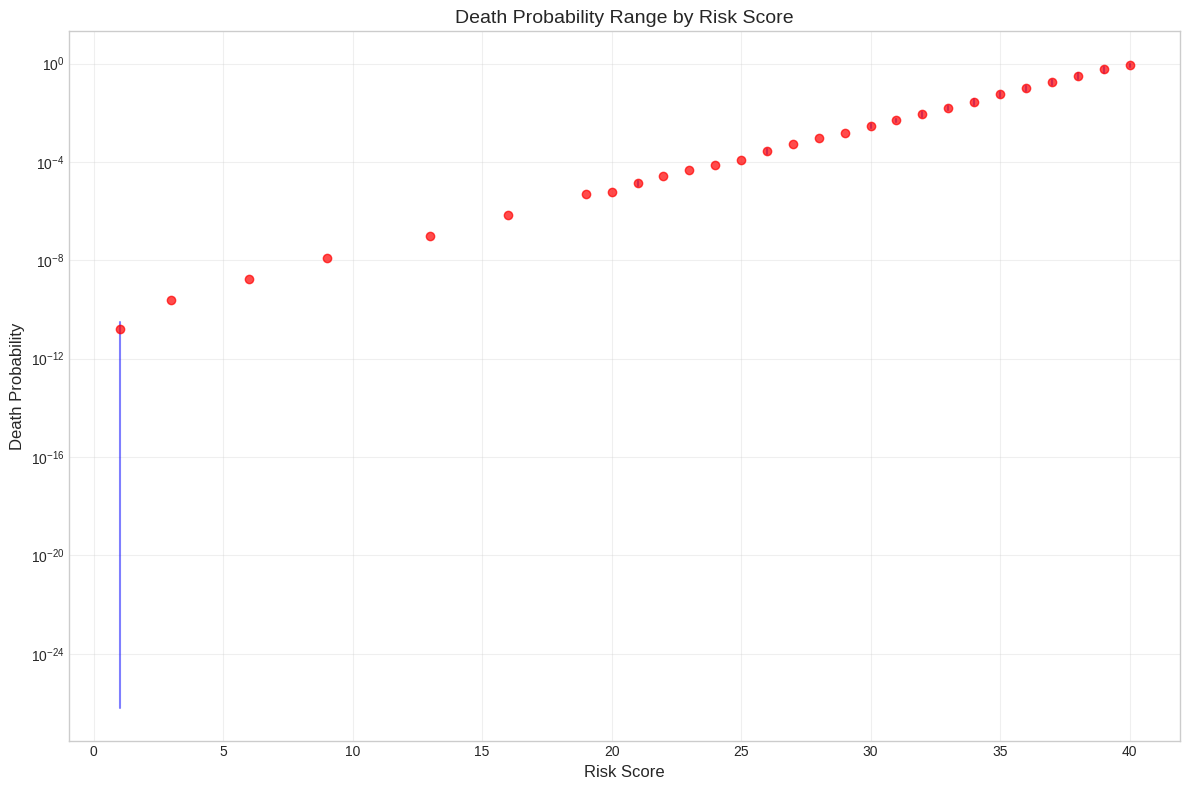

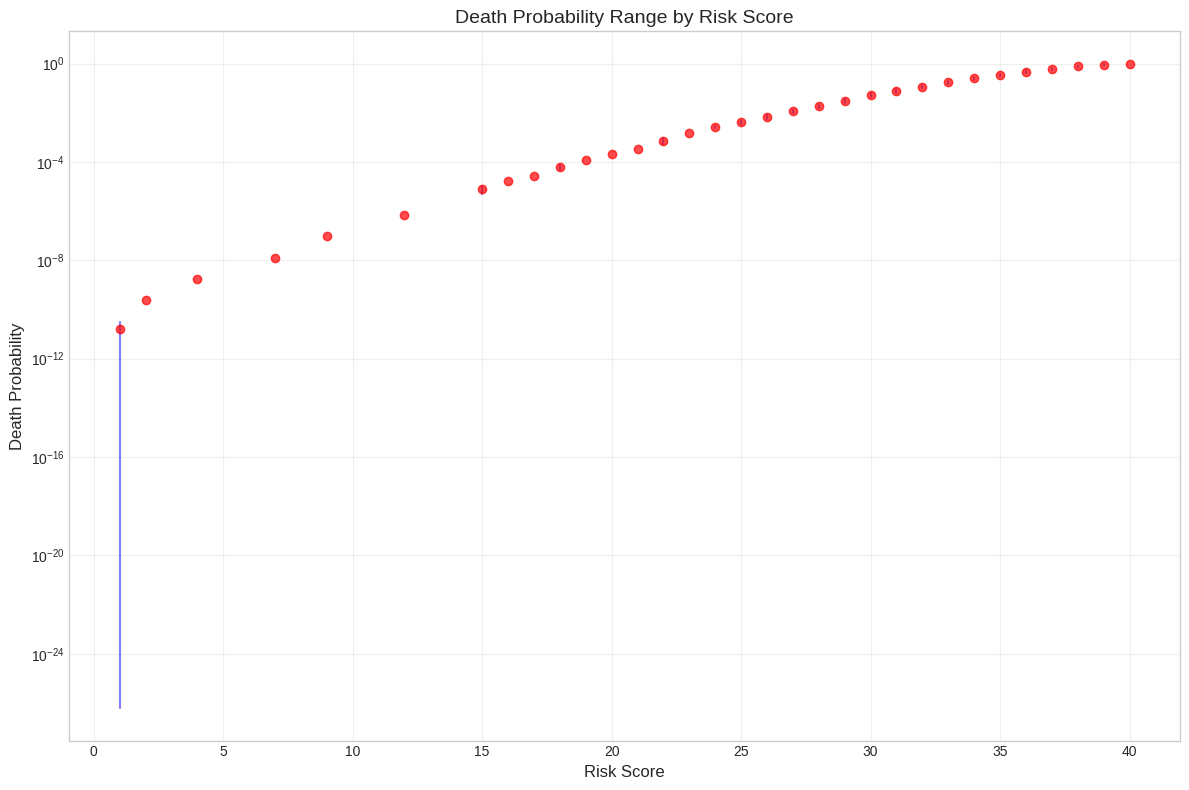

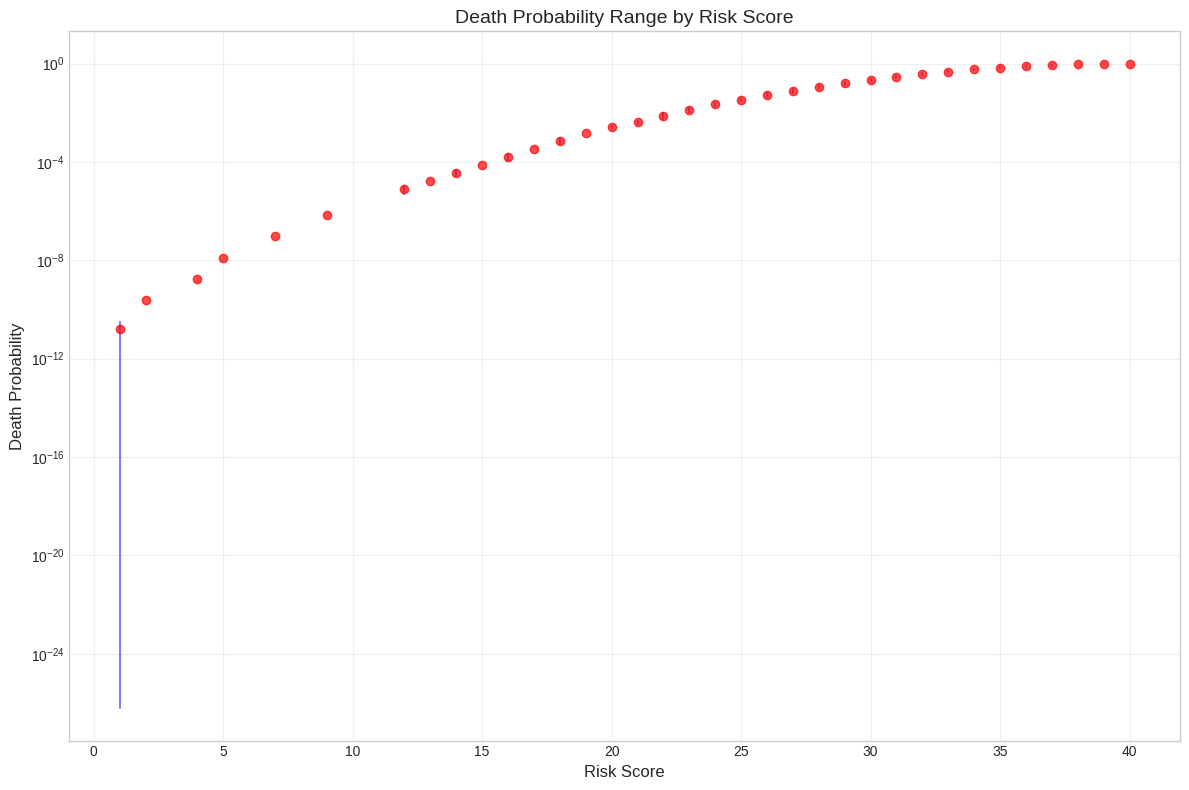

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def generate_improved_logarithmic_scores(max_score=40, granularity_factor=1.5):
    """
    Generate improved logarithmic risk scores with more granularity for higher risk groups.

    Parameters:
    -----------
    max_score : int, default=40
        Maximum risk score value
    granularity_factor : float, default=1.5
        Higher values increase granularity for higher risk scores

    Returns:
    --------
    dict : Results including dataframes and statistics
    """
    # Create more granular TTE values to ensure finer distinctions
    # Add more points in the critical ranges (0-90 days)
    tte_values = np.concatenate([
        np.arange(0, 10, 0.5),    # 0.5-day intervals for first 10 days
        np.arange(10, 30, 1),     # 1-day intervals from 10-30 days
        np.arange(30, 90, 2),     # 2-day intervals from 30-90 days
        np.arange(90, 180, 5),    # 5-day intervals from 90-180 days
        np.arange(180, 365, 15),  # 15-day intervals from 180-365 days
        np.arange(365, 731, 60),  # 60-day intervals from 1-2 years
        np.arange(731, 1826, 180) # 180-day intervals beyond 2 years
    ])

    # Lambda value for exponential transformation
    lambda_val = 30.0

    # Calculate death probabilities using exponential transformation
    death_probs = np.exp(-tte_values / lambda_val)

    # Enhanced logarithmic transformation
    # Add small epsilon to avoid log(0)
    epsilon = 1e-10
    log_probs = np.log(death_probs + epsilon)

    # Apply power transformation to increase granularity for higher probabilities
    # This stretches the higher end of the probability scale
    transformed_log_probs = np.sign(log_probs) * np.abs(log_probs) ** (1/granularity_factor)

    # Normalize to 1-max_score range
    min_transformed = np.min(transformed_log_probs)
    max_transformed = np.max(transformed_log_probs)
    scores_improved = 1 + (max_score - 1) * (transformed_log_probs - min_transformed) / (max_transformed - min_transformed)

    # Round to integers
    scores_improved = np.round(scores_improved).astype(int)
    scores_improved = np.clip(scores_improved, 1, max_score)

    # Create a dataframe with all values
    df = pd.DataFrame({
        'TTE_Days': tte_values,
        'Death_Probability': death_probs,
        'Log_Probability': log_probs,
        'Transformed_Log': transformed_log_probs,
        'Risk_Score': scores_improved
    })

    # Create reference table
    score_ranges = []

    for score in sorted(np.unique(scores_improved)):
        score_df = df[df['Risk_Score'] == score]
        min_prob = score_df['Death_Probability'].min()
        max_prob = score_df['Death_Probability'].max()
        min_tte = score_df['TTE_Days'].min()
        max_tte = score_df['TTE_Days'].max()

        score_ranges.append({
            'Risk_Score': int(score),
            'Min_TTE': min_tte,
            'Max_TTE': max_tte,
            'TTE_Range': f"{min_tte:.1f}-{max_tte:.1f}" if min_tte != max_tte else f"{min_tte:.1f}",
            'Min_Probability': min_prob,
            'Max_Probability': max_prob,
            'Count': len(score_df)
        })

    score_ranges_df = pd.DataFrame(score_ranges)

    # Create a recommended implementation table with simplified TTE ranges
    # Round to whole numbers for easier implementation
    implementation_table = []

    for score in sorted(np.unique(scores_improved)):
        score_df = df[df['Risk_Score'] == score]
        min_prob = score_df['Death_Probability'].min()
        max_prob = score_df['Death_Probability'].max()
        min_tte = np.floor(score_df['TTE_Days'].min())
        max_tte = np.ceil(score_df['TTE_Days'].max())

        implementation_table.append({
            'Risk_Score': int(score),
            'TTE_Range': f"{int(min_tte)}-{int(max_tte)}" if min_tte != max_tte else f"{int(min_tte)}",
            'Death_Probability_Range': f"{min_prob:.4f}-{max_prob:.4f}" if min_prob != max_prob else f"{min_prob:.4f}",
            'Avg_Probability': score_df['Death_Probability'].mean()
        })

    implementation_df = pd.DataFrame(implementation_table)

    # Visualize the relationship between Risk Score and Death Probability
    plt.figure(figsize=(12, 8))

    for i, score in enumerate(sorted(np.unique(scores_improved))):
        score_df = df[df['Risk_Score'] == score]
        min_prob = score_df['Death_Probability'].min()
        max_prob = score_df['Death_Probability'].max()
        mid_prob = (min_prob + max_prob) / 2

        plt.plot([score, score], [min_prob, max_prob], 'b-', alpha=0.5)
        plt.plot(score, mid_prob, 'ro', alpha=0.7)

    plt.xlabel('Risk Score', fontsize=12)
    plt.ylabel('Death Probability', fontsize=12)
    plt.title('Death Probability Range by Risk Score', fontsize=14)
    plt.yscale('log')  # Use log scale to better see the full range
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    return {
        'dataframe': df,
        'detailed_mapping': score_ranges_df,
        'implementation_table': implementation_df,
        'unique_scores': len(np.unique(scores_improved)),
        'plot': plt
    }

# Run the function with different granularity factors
# 1.0 = standard logarithmic, higher values = more granularity for higher risk
results_1 = generate_improved_logarithmic_scores(max_score=40, granularity_factor=1.0)
results_2 = generate_improved_logarithmic_scores(max_score=40, granularity_factor=1.5)
results_3 = generate_improved_logarithmic_scores(max_score=40, granularity_factor=2.0)

# Print the number of unique scores for each method
print(f"Standard Logarithmic (granularity=1.0): {results_1['unique_scores']} unique scores")
print(f"Enhanced Logarithmic (granularity=1.5): {results_2['unique_scores']} unique scores")
print(f"High Granularity (granularity=2.0): {results_3['unique_scores']} unique scores")

# Print the implementation table for the chosen method
print("\nImplementation Table (Enhanced Logarithmic, granularity=1.5):")
print(results_2['implementation_table'][['Risk_Score', 'TTE_Range', 'Avg_Probability']])

# Print detailed statistics for higher risk scores
high_risk_scores = results_2['implementation_table'][results_2['implementation_table']['Risk_Score'] >= 30]
print("\nDetailed Statistics for High Risk Scores (30-40):")
print(high_risk_scores[['Risk_Score', 'TTE_Range', 'Death_Probability_Range']])

# Save the implementation table
results_2['implementation_table'].to_csv('granular_risk_score_mapping.csv', index=False)

# Return the results
results_2

Time 7 days: 171 events out of 14632 patients (0.0117)
  MELD3 c-index: 0.8798
  Risk Score c-index: 0.8981
  Improvement: 0.0183
Time 14 days: 318 events out of 14632 patients (0.0217)
  MELD3 c-index: 0.8863
  Risk Score c-index: 0.9001
  Improvement: 0.0138
Time 30 days: 498 events out of 14632 patients (0.0340)
  MELD3 c-index: 0.8772
  Risk Score c-index: 0.8896
  Improvement: 0.0124


<ipython-input-38-b5d3f57714f2>:132: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  c_indices = pd.concat([c_indices, row_df], ignore_index=True)


Time 90 days: 837 events out of 14632 patients (0.0572)
  MELD3 c-index: 0.8411
  Risk Score c-index: 0.8485
  Improvement: 0.0074
  90-day AUC:  MELD3=0.7071, Risk Score=0.7128
  90-day Brier: MELD3=0.1408, Risk Score=0.2876
Time 180 days: 1139 events out of 14632 patients (0.0778)
  MELD3 c-index: 0.8135
  Risk Score c-index: 0.8168
  Improvement: 0.0033
Time 360 days: 1533 events out of 14632 patients (0.1048)
  MELD3 c-index: 0.7899
  Risk Score c-index: 0.7876
  Improvement: -0.0022


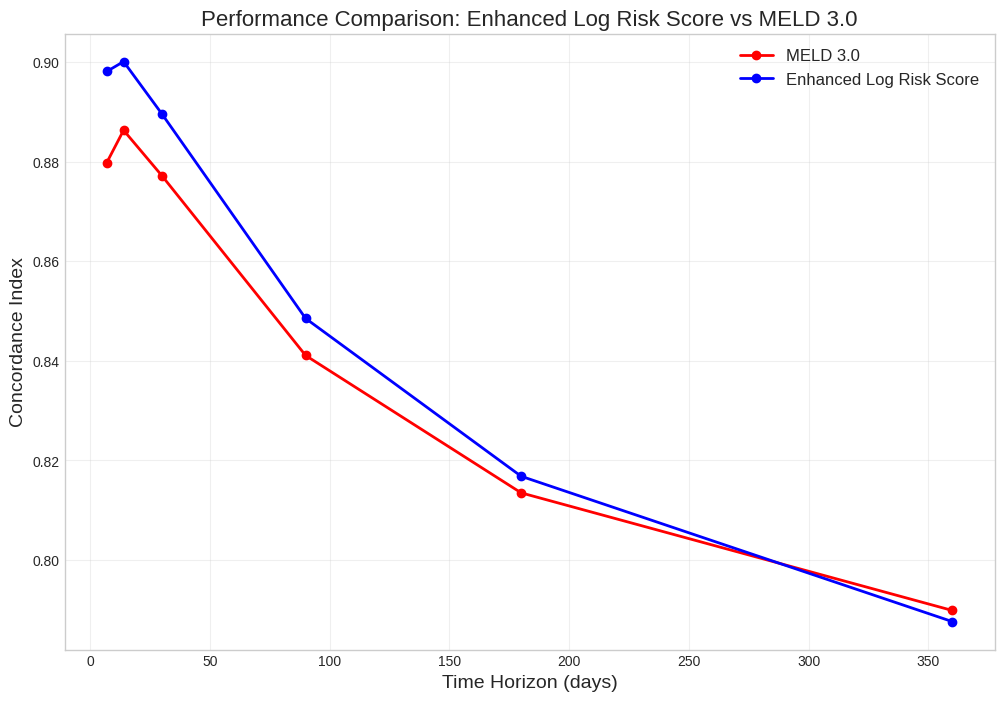

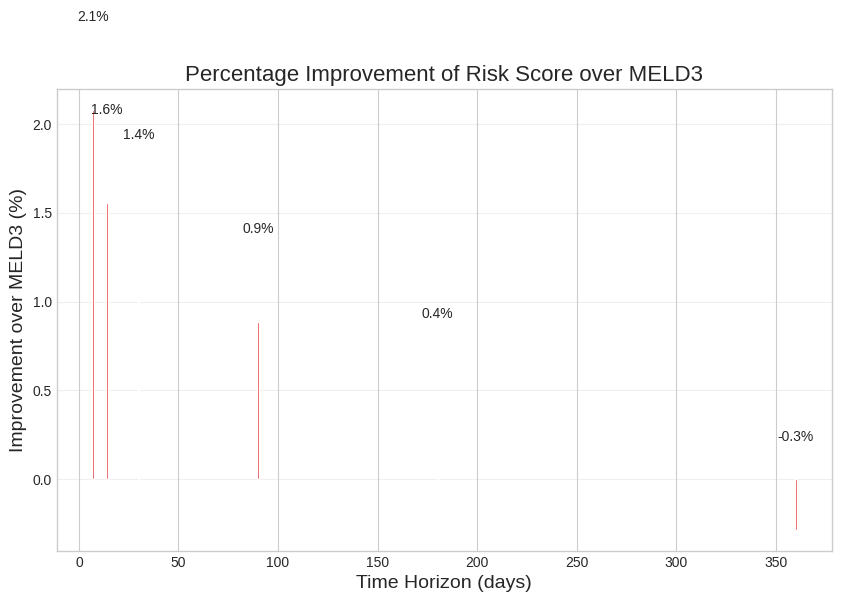


Concordance Index (C-index) comparison:
       Time   MELD3  Risk_Score  Difference  Improvement_Percentage
0    7 days  0.8798      0.8981      0.0183                  2.0797
1   14 days  0.8863      0.9001      0.0138                  1.5565
2   30 days  0.8772      0.8896      0.0124                  1.4153
3   90 days  0.8411      0.8485      0.0074                  0.8845
4  180 days  0.8135      0.8168      0.0033                  0.4095
5  360 days  0.7899      0.7876     -0.0022                 -0.2829


In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines.utils import concordance_index
from sklearn.metrics import roc_auc_score, brier_score_loss

def evaluate_risk_score_vs_meld3(test_df, time_points):
    """
    Evaluate the performance of the new risk score compared to MELD3.

    Parameters:
    -----------
    test_df : pandas.DataFrame
        Test dataset with 'tte', 'outcome', 'meld3' columns and the new risk score
    time_points : list
        List of time horizons (in days) to evaluate

    Returns:
    --------
    c_indices : pandas.DataFrame
        Concordance indices for each model at each time point
    """
    # Add the enhanced logarithmic risk score (from TTE) to the test data
    # This assumes test_df already has a TTE prediction column
    def tte_to_risk_score(tte, lambda_val=30.0, granularity_factor=1.5):
        """Convert TTE to risk score using enhanced logarithmic approach"""
        # Add small epsilon to avoid log(0)
        epsilon = 1e-10

        # Apply exponential transformation to get probability
        prob = np.exp(-tte / lambda_val)

        # Apply logarithmic transformation with enhanced granularity
        log_prob = np.log(prob + epsilon)
        transformed_log = np.sign(log_prob) * np.abs(log_prob) ** (1/granularity_factor)

        # Get min/max values for normalization (hardcoded from previous analysis)
        min_transformed = -8.093638  # From the lowest TTE
        max_transformed = 2.154435e-07  # From TTE=0

        # Convert to 1-40 scale
        score = 1 + 39 * (transformed_log - min_transformed) / (max_transformed - min_transformed)
        score = np.round(score).astype(int)
        score = np.clip(score, 1, 40)

        return score

    # Calculate risk score for each patient
    # If test_df has predicted_tte column, use it directly
    # Otherwise, use the nearest neighbor approach with best k
    if 'predicted_tte' in test_df.columns:
        test_df['risk_score'] = test_df['predicted_tte'].apply(
            lambda x: tte_to_risk_score(x)
        )
    elif 'predicted_tte_k300' in test_df.columns:  # Assuming k=300 as an example
        test_df['risk_score'] = test_df['predicted_tte_k300'].apply(
            lambda x: tte_to_risk_score(x)
        )

    # Create DataFrame to store results
    c_indices = pd.DataFrame(columns=['Time', 'MELD3', 'Risk_Score', 'Difference'])

    # For each time point, calculate concordance indices and other metrics
    for t in time_points:
        # Create subset for patients at risk at time t
        at_risk = test_df.copy()

        # Handle times and events properly:
        # First, cap all times at time t
        at_risk['time'] = np.minimum(at_risk['tte'], t)

        # Mark events: only death (outcome=0) counts as an event
        # Transplant (outcome=2) and waiting/censored (outcome=1) are both treated as censored
        at_risk['event'] = ((at_risk['outcome'] == 0) & (at_risk['tte'] <= t)).astype(int)

        # Print event rate
        event_count = at_risk['event'].sum()
        event_rate = event_count / len(at_risk)
        print(f"Time {t} days: {event_count} events out of {len(at_risk)} patients ({event_rate:.4f})")

        # Skip if no events
        if event_count == 0:
            print(f"  No events at {t} days, skipping")
            row_dict = {'Time': f"{t} days", 'MELD3': np.nan, 'Risk_Score': np.nan, 'Difference': np.nan}
            row_df = pd.DataFrame([row_dict])
            c_indices = pd.concat([c_indices, row_df], ignore_index=True)
            continue

        # Calculate c-index for MELD3 (higher score = higher risk)
        # Note: concordance_index expects higher values to indicate LOWER risk by default
        # So we need to flip the sign to match convention
        c_meld3 = 1 - concordance_index(at_risk['time'], at_risk['meld3'], at_risk['event'])
        print(f"  MELD3 c-index: {c_meld3:.4f}")

        # Calculate c-index for risk score (higher score = higher risk, needs to be flipped)
        c_risk_score = 1 - concordance_index(at_risk['time'], at_risk['risk_score'], at_risk['event'])
        print(f"  Risk Score c-index: {c_risk_score:.4f}")

        # Calculate difference
        diff = c_risk_score - c_meld3
        print(f"  Improvement: {diff:.4f}")

        # Calculate additional metrics for 90-day prediction if this is 90-day timepoint
        if t == 90:
            # Binary outcome for 90-day mortality
            binary_outcome = at_risk['event']

            # Predicted probabilities (need to normalize to 0-1)
            meld_prob = (at_risk['meld3'] - at_risk['meld3'].min()) / (at_risk['meld3'].max() - at_risk['meld3'].min())
            risk_prob = (at_risk['risk_score'] - 1) / 39  # Scale from 1-40 to 0-1

            # Calculate AUC
            auc_meld3 = roc_auc_score(binary_outcome, meld_prob)
            auc_risk = roc_auc_score(binary_outcome, risk_prob)
            print(f"  90-day AUC:  MELD3={auc_meld3:.4f}, Risk Score={auc_risk:.4f}")

            # Calculate Brier score
            brier_meld3 = brier_score_loss(binary_outcome, meld_prob)
            brier_risk = brier_score_loss(binary_outcome, risk_prob)
            print(f"  90-day Brier: MELD3={brier_meld3:.4f}, Risk Score={brier_risk:.4f}")

        # Add to results
        row_dict = {
            'Time': f"{t} days",
            'MELD3': c_meld3,
            'Risk_Score': c_risk_score,
            'Difference': diff
        }

        # Create a new DataFrame for this row and concatenate
        row_df = pd.DataFrame([row_dict])
        c_indices = pd.concat([c_indices, row_df], ignore_index=True)

    # Calculate improvement percentage
    c_indices['Improvement_Percentage'] = (c_indices['Difference'] / c_indices['MELD3'] * 100)

    return c_indices

def plot_performance_comparison(c_indices, output_file=None):
    """
    Plot performance comparison between MELD3 and the new risk score.
    """
    # Extract time points
    time_points = [int(t.split()[0]) for t in c_indices['Time']]

    # Create the plot
    plt.figure(figsize=(12, 8))

    # Plot concordance indices
    plt.plot(time_points, c_indices['MELD3'], 'ro-', linewidth=2, label='MELD 3.0')
    plt.plot(time_points, c_indices['Risk_Score'], 'bo-', linewidth=2, label='Enhanced Log Risk Score')

    # Add labels and title
    plt.xlabel('Time Horizon (days)', fontsize=14)
    plt.ylabel('Concordance Index', fontsize=14)
    plt.title('Performance Comparison: Enhanced Log Risk Score vs MELD 3.0', fontsize=16)

    # Add grid and legend
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)

    # Save if output file is provided
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()

    # Create another plot for improvement percentage
    plt.figure(figsize=(10, 6))
    plt.bar(time_points, c_indices['Improvement_Percentage'])
    plt.xlabel('Time Horizon (days)', fontsize=14)
    plt.ylabel('Improvement over MELD3 (%)', fontsize=14)
    plt.title('Percentage Improvement of Risk Score over MELD3', fontsize=16)
    plt.grid(axis='y', alpha=0.3)

    # Add values above bars
    for i, v in enumerate(c_indices['Improvement_Percentage']):
        if not np.isnan(v):
            plt.text(time_points[i], v + 0.5, f"{v:.1f}%", ha='center')

    # Save if output file is provided
    if output_file:
        base_name = output_file.split('.')[0]
        plt.savefig(f"{base_name}_improvement.png", dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()

def stratify_by_meld_category(test_df, t=90):
    """
    Analyze performance across MELD 3.0 categories.
    """
    # Define MELD categories
    meld_categories = [
        (6, 15, 'MELD 6-15'),
        (16, 20, 'MELD 16-20'),
        (21, 25, 'MELD 21-25'),
        (26, 30, 'MELD 26-30'),
        (31, 40, 'MELD 31-40')
    ]

    # Create DataFrame to store results
    stratified_results = []

    for lower, upper, label in meld_categories:
        # Select patients in this MELD range
        meld_group = test_df[(test_df['meld3'] >= lower) & (test_df['meld3'] <= upper)]

        if len(meld_group) > 10:  # Only analyze groups with enough patients
            # Calculate c-indices for t-day mortality with proper censoring
            at_risk = meld_group.copy()
            at_risk['time'] = np.minimum(at_risk['tte'], t)
            at_risk['event'] = ((at_risk['outcome'] == 0) & (at_risk['tte'] <= t)).astype(int)

            # Skip if no events
            if at_risk['event'].sum() == 0:
                continue

            # C-index for MELD 3.0 (properly oriented)
            c_meld3 = 1 - concordance_index(at_risk['time'], at_risk['meld3'], at_risk['event'])

            # C-index for risk score (properly oriented)
            c_risk_score = 1 - concordance_index(at_risk['time'], at_risk['risk_score'], at_risk['event'])

            # Store results
            stratified_results.append({
                'MELD_Group': label,
                'Patients': len(meld_group),
                'Events': at_risk['event'].sum(),
                'Event_Rate': at_risk['event'].mean() * 100,
                'C_index_MELD3': c_meld3,
                'C_index_Risk_Score': c_risk_score,
                'Difference': c_risk_score - c_meld3,
                'Improvement_Percentage': (c_risk_score - c_meld3) / c_meld3 * 100
            })

    # Convert to DataFrame
    stratified_df = pd.DataFrame(stratified_results)

    # Plot stratified results
    if not stratified_df.empty:
        plt.figure(figsize=(12, 8))

        # Create bar positions
        bar_width = 0.35
        x = np.arange(len(stratified_df))

        # Plot bars
        plt.bar(x - bar_width/2, stratified_df['C_index_MELD3'],
                width=bar_width, label='MELD 3.0', color='lightcoral')
        plt.bar(x + bar_width/2, stratified_df['C_index_Risk_Score'],
                width=bar_width, label='Enhanced Log Risk Score', color='skyblue')

        # Add labels and title
        plt.xlabel('MELD 3.0 Category', fontsize=14)
        plt.ylabel(f'Concordance Index ({t}-day)', fontsize=14)
        plt.title(f'C-index Comparison by MELD 3.0 Category ({t}-day mortality)', fontsize=16)

        # Set x-ticks
        plt.xticks(x, stratified_df['MELD_Group'])

        # Add grid and legend
        plt.grid(axis='y', alpha=0.3)
        plt.legend(fontsize=12)

        # Add patient count and event rate labels
        for i, row in enumerate(stratified_df.itertuples()):
            plt.text(i, 0.1, f"n={row.Patients}\n({row.Event_Rate:.1f}%)",
                    ha='center', fontsize=10)

            # Add improvement percentages at the top
            improvement = row.Improvement_Percentage
            max_height = max(row.C_index_MELD3, row.C_index_Risk_Score)
            plt.text(i, max_height + 0.02, f"+{improvement:.1f}%",
                    ha='center', fontsize=10, color='green')

        # Show the plot
        plt.tight_layout()
        plt.savefig(f"stratified_c_index_{t}day.png", dpi=300, bbox_inches='tight')
        plt.show()

    return stratified_df

# Example usage
if __name__ == "__main__":
    # This is a placeholder for demonstration - you'll need to adapt the function calls
    # to your actual data structure

    # Define time points to evaluate - these should match your original analysis
    time_points = [7, 14, 30, 90, 180, 360]

    # # Evaluate on test data (assuming test_df is already defined)
    c_indices = evaluate_risk_score_vs_meld3(test_df, time_points)
    #
    # # Plot results
    plot_performance_comparison(c_indices, 'risk_score_vs_meld3.png')
    #
    # # Stratified analysis
    # stratified_results = stratify_by_meld_category(test_df, t=90)
    #
    # # Print results
    print("\nConcordance Index (C-index) comparison:")
    print(c_indices.round(4))
    #
    # print("\nStratified Analysis by MELD 3.0 Category (90-day mortality):")
    # print(stratified_results.round(4))

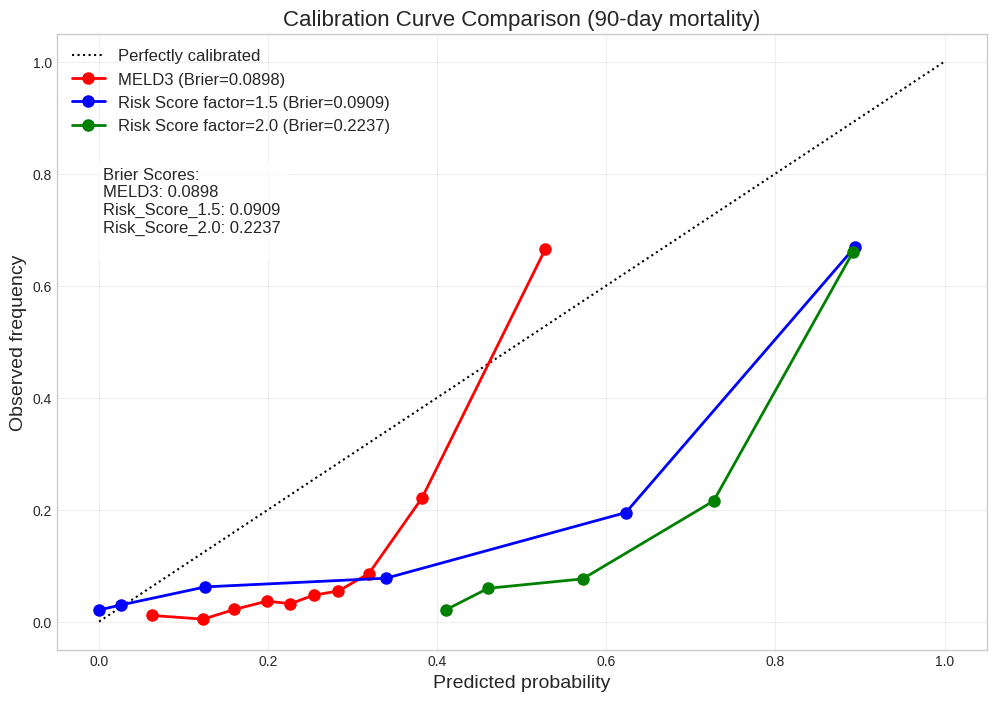


Improving calibration with isotonic regression:
MELD3: Original Brier=0.0898, Calibrated Brier=0.0599, Improvement=0.0299 (33.31%)
Risk_Score_1.5: Original Brier=0.0909, Calibrated Brier=0.0578, Improvement=0.0332 (36.46%)
Risk_Score_2.0: Original Brier=0.2237, Calibrated Brier=0.0580, Improvement=0.1657 (74.06%)


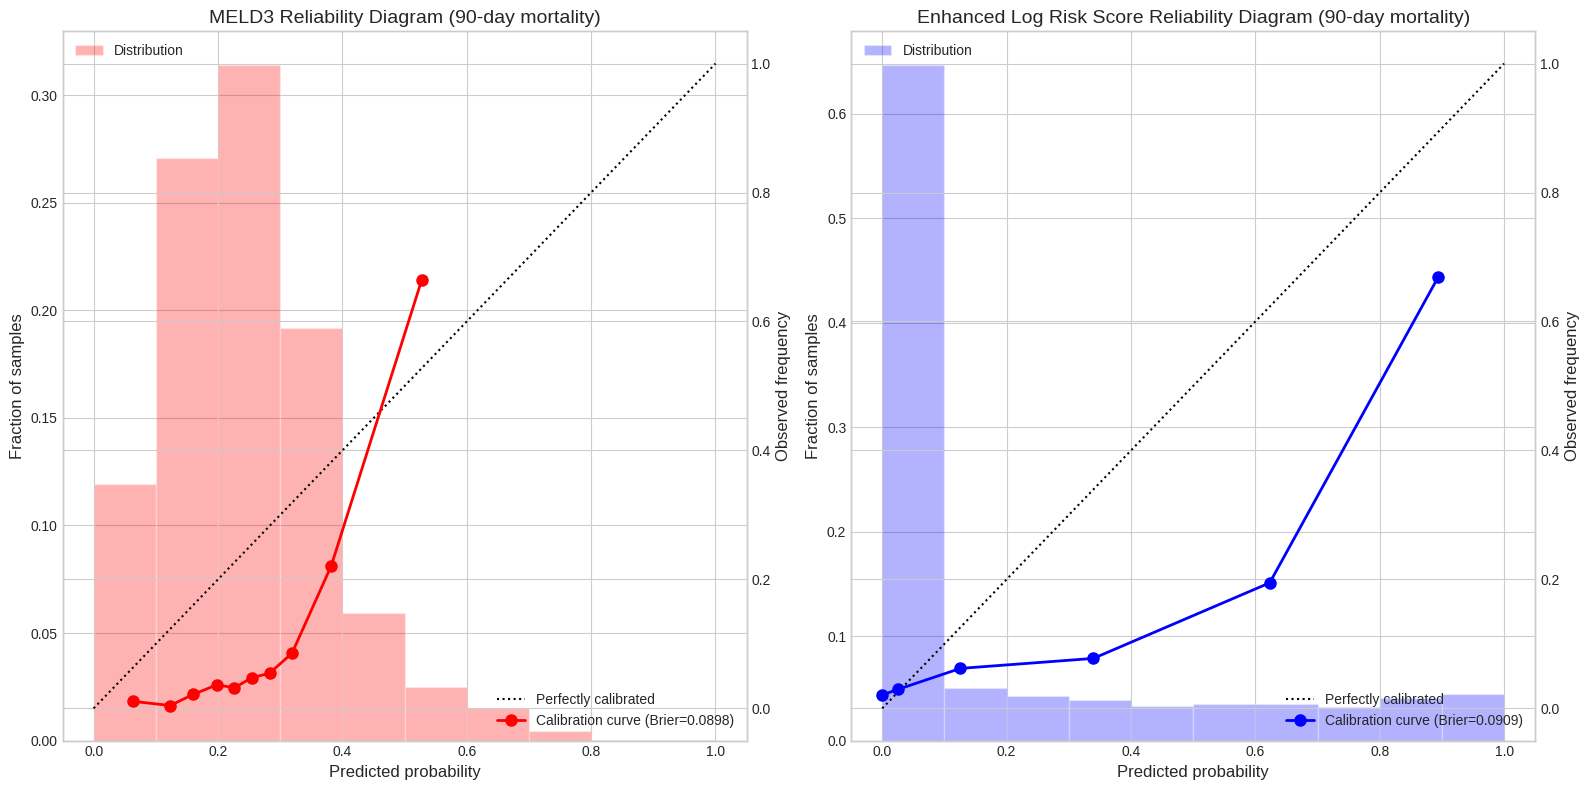

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
from sklearn.isotonic import IsotonicRegression

def compare_calibration(test_df, time_horizon=90, granularity_factors=[1.5, 2.0], n_bins=10):
    """
    Generate calibration curves and calculate Brier scores comparing risk scores vs MELD 3.0.

    Parameters:
    -----------
    test_df : pandas.DataFrame
        Test dataset with 'tte', 'outcome', 'meld3', and risk score columns
    time_horizon : int, default=90
        Time horizon in days for mortality prediction
    granularity_factors : list, default=[1.5, 2.0]
        List of granularity factors for risk scores to evaluate
    n_bins : int, default=10
        Number of bins for calibration curve

    Returns:
    --------
    dict : Dictionary with calibration metrics and results
    """
    # Create a copy of the dataframe to avoid modifying the original
    df = test_df.copy()

    # Function to calculate risk score
    def tte_to_risk_score(tte, lambda_val=30.0, granularity_factor=1.5):
        """Convert TTE to risk score using enhanced logarithmic approach"""
        # Add small epsilon to avoid log(0)
        epsilon = 1e-10

        # Apply exponential transformation to get probability
        prob = np.exp(-tte / lambda_val)

        # Apply logarithmic transformation with enhanced granularity
        log_prob = np.log(prob + epsilon)
        transformed_log = np.sign(log_prob) * np.abs(log_prob) ** (1/granularity_factor)

        # Get min/max values for normalization (hardcoded from previous analysis)
        min_transformed = -8.093638  # From the lowest TTE
        max_transformed = 2.154435e-07  # From TTE=0

        # Convert to 1-40 scale
        score = 1 + 39 * (transformed_log - min_transformed) / (max_transformed - min_transformed)
        score = np.round(score).astype(int)
        score = np.clip(score, 1, 40)

        return score

    # Identify the TTE column to use
    if 'predicted_tte' in df.columns:
        tte_col = 'predicted_tte'
    elif 'predicted_tte_k300' in df.columns:
        tte_col = 'predicted_tte_k300'
    else:
        tte_cols = [col for col in df.columns if col.startswith('predicted_tte')]
        if tte_cols:
            tte_col = tte_cols[0]
        else:
            raise ValueError("No predicted TTE column found in the dataset")

    # Calculate risk scores for each granularity factor
    for factor in granularity_factors:
        col_name = f'risk_score_{factor}'
        df[col_name] = df[tte_col].apply(lambda x: tte_to_risk_score(x, granularity_factor=factor))

    # Define the binary outcome for mortality at the specified time horizon
    # Properly handle censoring (only count deaths as events, treat transplants as censored)
    df['mortality'] = ((df['outcome'] == 0) & (df['tte'] <= time_horizon)).astype(int)

    # Create mask for proper evaluation (exclude patients who got transplant before time_horizon)
    eval_mask = (df['outcome'] != 2) | (df['tte'] > time_horizon)

    # Normalize MELD3 scores to [0,1] range for probability interpretation
    meld_min = df['meld3'].min()
    meld_max = df['meld3'].max()
    df['meld3_prob'] = (df['meld3'] - meld_min) / (meld_max - meld_min)

    # Convert risk scores to probabilities (1-40 scale to 0-1)
    for factor in granularity_factors:
        col_name = f'risk_score_{factor}'
        df[f'{col_name}_prob'] = (df[col_name] - 1) / 39

    # Results dictionary
    results = {
        'models': ['MELD3'] + [f'Risk_Score_{factor}' for factor in granularity_factors],
        'brier_scores': {},
        'calibration_data': {}
    }

    # Calculate calibration curves and Brier scores
    # First for MELD3
    y_true = df.loc[eval_mask, 'mortality']
    meld_prob = df.loc[eval_mask, 'meld3_prob']

    # Calculate calibration curve for MELD3
    prob_true, prob_pred = calibration_curve(
        y_true, meld_prob, n_bins=n_bins, strategy='quantile'
    )

    # Calculate Brier score for MELD3
    brier_meld = brier_score_loss(y_true, meld_prob)

    # Store results for MELD3
    results['brier_scores']['MELD3'] = brier_meld
    results['calibration_data']['MELD3'] = {
        'prob_true': prob_true,
        'prob_pred': prob_pred
    }

    # Now for each risk score
    for factor in granularity_factors:
        model_name = f'Risk_Score_{factor}'
        prob_col = f'risk_score_{factor}_prob'
        risk_prob = df.loc[eval_mask, prob_col]

        # Calculate calibration curve
        prob_true, prob_pred = calibration_curve(
            y_true, risk_prob, n_bins=n_bins, strategy='quantile'
        )

        # Calculate Brier score
        brier_risk = brier_score_loss(y_true, risk_prob)

        # Store results
        results['brier_scores'][model_name] = brier_risk
        results['calibration_data'][model_name] = {
            'prob_true': prob_true,
            'prob_pred': prob_pred
        }

    # Create calibration plot
    plt.figure(figsize=(12, 8))

    # Plot diagonal (perfect calibration)
    plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')

    # Colors for different models
    colors = ['red', 'blue', 'green', 'purple', 'orange']

    # Plot MELD3 calibration
    cal_data = results['calibration_data']['MELD3']
    plt.plot(cal_data['prob_pred'], cal_data['prob_true'], 'o-',
             label=f'MELD3 (Brier={results["brier_scores"]["MELD3"]:.4f})',
             color=colors[0], linewidth=2, markersize=8)

    # Plot risk score calibrations
    for i, factor in enumerate(granularity_factors):
        model_name = f'Risk_Score_{factor}'
        cal_data = results['calibration_data'][model_name]
        plt.plot(cal_data['prob_pred'], cal_data['prob_true'], 'o-',
                 label=f'Risk Score factor={factor} (Brier={results["brier_scores"][model_name]:.4f})',
                 color=colors[i+1], linewidth=2, markersize=8)

    # Add labels and title
    plt.xlabel('Predicted probability', fontsize=14)
    plt.ylabel('Observed frequency', fontsize=14)
    plt.title(f'Calibration Curve Comparison ({time_horizon}-day mortality)', fontsize=16)

    # Add grid and legend
    plt.grid(True, alpha=0.3)
    plt.legend(loc='upper left', fontsize=12)

    # Add text with Brier scores summary
    brier_text = "Brier Scores:\n"
    for model in results['models']:
        brier_text += f"{model}: {results['brier_scores'][model]:.4f}\n"

    plt.text(0.05, 0.65, brier_text,
             transform=plt.gca().transAxes, fontsize=12,
             bbox=dict(facecolor='white', alpha=0.8))

    # Save the plot
    plt.savefig(f'calibration_comparison_{time_horizon}days.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Additionally, try to improve calibration with isotonic regression
    print("\nImproving calibration with isotonic regression:")

    improved_results = {model: {} for model in results['models']}

    for model in results['models']:
        if model == 'MELD3':
            prob_col = 'meld3_prob'
        else:
            factor = float(model.split('_')[-1])
            prob_col = f'risk_score_{factor}_prob'

        # Fit isotonic regression to improve calibration
        iso_reg = IsotonicRegression(out_of_bounds='clip')
        y_prob = df.loc[eval_mask, prob_col].values
        iso_reg.fit(y_prob, y_true)

        # Generate calibrated probabilities
        calibrated_prob = iso_reg.predict(y_prob)

        # Calculate improved Brier score
        improved_brier = brier_score_loss(y_true, calibrated_prob)
        improvement = results['brier_scores'][model] - improved_brier

        improved_results[model]['original_brier'] = results['brier_scores'][model]
        improved_results[model]['calibrated_brier'] = improved_brier
        improved_results[model]['improvement'] = improvement
        improved_results[model]['improvement_pct'] = (improvement / results['brier_scores'][model]) * 100

        print(f"{model}: Original Brier={results['brier_scores'][model]:.4f}, "
              f"Calibrated Brier={improved_brier:.4f}, "
              f"Improvement={improvement:.4f} ({improved_results[model]['improvement_pct']:.2f}%)")

    # Return both raw and improved results
    return {
        'raw_results': results,
        'improved_results': improved_results
    }

def create_reliability_diagram(test_df, time_horizon=90, n_bins=10):
    """
    Create a reliability diagram comparing MELD3 and risk scores using histograms.

    Parameters:
    -----------
    test_df : pandas.DataFrame
        Test dataset
    time_horizon : int, default=90
        Time horizon in days for mortality prediction
    n_bins : int, default=10
        Number of bins for the diagram

    Returns:
    --------
    None (displays the plot)
    """
    # Create a copy of the dataframe to avoid modifying the original
    df = test_df.copy()

    # Function to calculate risk score with granularity factor 1.5
    def tte_to_risk_score(tte, lambda_val=30.0, granularity_factor=1.5):
        """Convert TTE to risk score using enhanced logarithmic approach"""
        # Add small epsilon to avoid log(0)
        epsilon = 1e-10

        # Apply exponential transformation to get probability
        prob = np.exp(-tte / lambda_val)

        # Apply logarithmic transformation with enhanced granularity
        log_prob = np.log(prob + epsilon)
        transformed_log = np.sign(log_prob) * np.abs(log_prob) ** (1/granularity_factor)

        # Get min/max values for normalization (hardcoded from previous analysis)
        min_transformed = -8.093638  # From the lowest TTE
        max_transformed = 2.154435e-07  # From TTE=0

        # Convert to 1-40 scale
        score = 1 + 39 * (transformed_log - min_transformed) / (max_transformed - min_transformed)
        score = np.round(score).astype(int)
        score = np.clip(score, 1, 40)

        return score

    # Identify the TTE column to use
    if 'predicted_tte' in df.columns:
        tte_col = 'predicted_tte'
    elif 'predicted_tte_k300' in df.columns:
        tte_col = 'predicted_tte_k300'
    else:
        tte_cols = [col for col in df.columns if col.startswith('predicted_tte')]
        if tte_cols:
            tte_col = tte_cols[0]
        else:
            raise ValueError("No predicted TTE column found in the dataset")

    # Calculate risk score
    df['risk_score'] = df[tte_col].apply(lambda x: tte_to_risk_score(x))

    # Define the binary outcome for mortality at the specified time horizon
    df['mortality'] = ((df['outcome'] == 0) & (df['tte'] <= time_horizon)).astype(int)

    # Create mask for proper evaluation (exclude patients who got transplant before time_horizon)
    eval_mask = (df['outcome'] != 2) | (df['tte'] > time_horizon)

    # Normalize MELD3 scores to [0,1] range for probability interpretation
    meld_min = df['meld3'].min()
    meld_max = df['meld3'].max()
    df['meld3_prob'] = (df['meld3'] - meld_min) / (meld_max - meld_min)

    # Convert risk score to probability (1-40 scale to 0-1)
    df['risk_score_prob'] = (df['risk_score'] - 1) / 39

    # Filter the dataset
    df_eval = df[eval_mask].copy()

    # Create a figure with 2 subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # For MELD3
    y_true = df_eval['mortality']
    meld_prob = df_eval['meld3_prob']

    # Calculate calibration curve for MELD3
    prob_true, prob_pred = calibration_curve(
        y_true, meld_prob, n_bins=n_bins, strategy='quantile'
    )

    # Calculate Brier score for MELD3
    brier_meld = brier_score_loss(y_true, meld_prob)

    # Create bin edges and counts for the histogram
    bin_edges = np.linspace(0, 1, n_bins + 1)
    bin_indices = np.digitize(meld_prob, bin_edges) - 1
    bin_indices = np.clip(bin_indices, 0, n_bins - 1)
    bin_counts = np.bincount(bin_indices, minlength=n_bins)

    # Plot MELD3 reliability diagram
    ax = axes[0]
    width = 1.0 / n_bins
    bin_centers = bin_edges[:-1] + width / 2

    # Plot the histogram of predicted probabilities
    ax.bar(bin_centers, bin_counts / np.sum(bin_counts), width=width,
           alpha=0.3, color='red', label='Distribution')

    # Create a twin axis for the calibration curve
    ax2 = ax.twinx()
    ax2.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')
    ax2.plot(prob_pred, prob_true, 'ro-', linewidth=2, markersize=8,
             label=f'Calibration curve (Brier={brier_meld:.4f})')

    # Set labels and title
    ax.set_xlabel('Predicted probability', fontsize=12)
    ax.set_ylabel('Fraction of samples', fontsize=12)
    ax2.set_ylabel('Observed frequency', fontsize=12)
    ax.set_title(f'MELD3 Reliability Diagram ({time_horizon}-day mortality)', fontsize=14)

    # Add legends
    ax.legend(loc='upper left', fontsize=10)
    ax2.legend(loc='lower right', fontsize=10)

    # For Risk Score
    risk_prob = df_eval['risk_score_prob']

    # Calculate calibration curve for Risk Score
    prob_true, prob_pred = calibration_curve(
        y_true, risk_prob, n_bins=n_bins, strategy='quantile'
    )

    # Calculate Brier score for Risk Score
    brier_risk = brier_score_loss(y_true, risk_prob)

    # Create bin edges and counts for the histogram
    bin_indices = np.digitize(risk_prob, bin_edges) - 1
    bin_indices = np.clip(bin_indices, 0, n_bins - 1)
    bin_counts = np.bincount(bin_indices, minlength=n_bins)

    # Plot Risk Score reliability diagram
    ax = axes[1]

    # Plot the histogram of predicted probabilities
    ax.bar(bin_centers, bin_counts / np.sum(bin_counts), width=width,
           alpha=0.3, color='blue', label='Distribution')

    # Create a twin axis for the calibration curve
    ax2 = ax.twinx()
    ax2.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')
    ax2.plot(prob_pred, prob_true, 'bo-', linewidth=2, markersize=8,
             label=f'Calibration curve (Brier={brier_risk:.4f})')

    # Set labels and title
    ax.set_xlabel('Predicted probability', fontsize=12)
    ax.set_ylabel('Fraction of samples', fontsize=12)
    ax2.set_ylabel('Observed frequency', fontsize=12)
    ax.set_title(f'Enhanced Log Risk Score Reliability Diagram ({time_horizon}-day mortality)', fontsize=14)

    # Add legends
    ax.legend(loc='upper left', fontsize=10)
    ax2.legend(loc='lower right', fontsize=10)

    # Adjust layout
    plt.tight_layout()
    plt.savefig(f'reliability_diagram_{time_horizon}days.png', dpi=300, bbox_inches='tight')
    plt.show()

# Example usage
if __name__ == "__main__":
    # Define time horizon
    time_horizon = 90  # 90-day mortality

    # Define granularity factors
    granularity_factors = [1.5, 2.0]

    # # Compare calibration
    calibration_results = compare_calibration(test_df, time_horizon, granularity_factors)
    #
    # # Create reliability diagram
    create_reliability_diagram(test_df, time_horizon)

Using predicted_tte_k300 for predictions
Total patients: 14632
Patients used for calibration: 7685
Patients excluded (transplant before 90 days): 6947

Performance metrics:

90-day metrics:
  C-index (all patients with censoring):
    MELD3=0.8411, Risk Score=0.8591, Diff=0.0180
  AUC (excluding transplanted patients):
    MELD3=0.8771, Risk Score=0.8918, Diff=0.0147
  Brier Score (excluding transplanted patients):
    MELD3=0.0898, Risk Score=0.0572, Diff=0.0326

180-day metrics:
  C-index (all patients with censoring):
    MELD3=0.8135, Risk Score=0.8298, Diff=0.0163
  AUC (excluding transplanted patients):
    MELD3=0.8431, Risk Score=0.8557, Diff=0.0125
  Brier Score (excluding transplanted patients):
    MELD3=0.1124, Risk Score=0.0994, Diff=0.0130

360-day metrics:
  C-index (all patients with censoring):
    MELD3=0.7899, Risk Score=0.8050, Diff=0.0152
  AUC (excluding transplanted patients):
    MELD3=0.8124, Risk Score=0.8237, Diff=0.0113
  Brier Score (excluding transplanted 

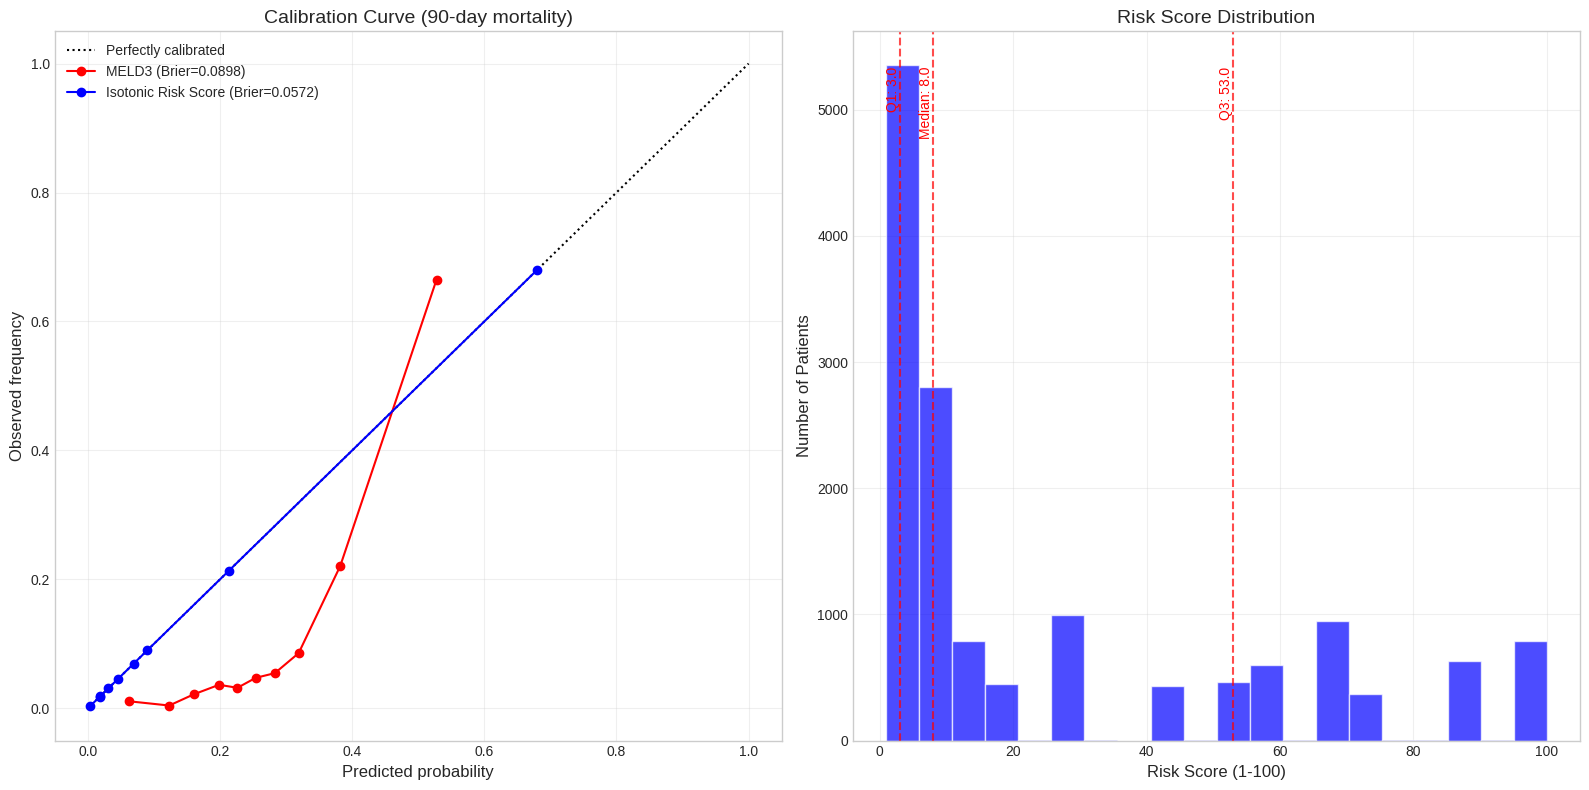

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.isotonic import IsotonicRegression
from lifelines.utils import concordance_index
from sklearn.metrics import roc_auc_score, brier_score_loss

# Try to import calibration_curve from its new location first
try:
    from sklearn.calibration import calibration_curve
except ImportError:
    # Fall back to old location for older scikit-learn versions
    try:
        from sklearn.metrics import calibration_curve
    except ImportError:
        # If not available in either location, define our own implementation
        def calibration_curve(y_true, y_prob, n_bins=5, strategy='uniform'):
            """Custom implementation of calibration curve."""
            y_true = np.array(y_true)
            y_prob = np.array(y_prob)

            # Sort by predicted probability
            idx_sorted = np.argsort(y_prob)
            y_true = y_true[idx_sorted]
            y_prob = y_prob[idx_sorted]

            if strategy == 'quantile':
                # Quantile binning (equal number of samples in each bin)
                quantiles = np.linspace(0, 1, n_bins + 1)
                bins = np.percentile(y_prob, quantiles * 100)
                # Fix for duplicates in bins
                bins = np.unique(bins)
            else:
                # Uniform binning (equal bin widths)
                bins = np.linspace(0, 1, n_bins + 1)

            bin_indices = np.digitize(y_prob, bins[1:])

            bin_sums = np.bincount(bin_indices, weights=y_true, minlength=len(bins)-1)
            bin_counts = np.bincount(bin_indices, minlength=len(bins)-1)
            nonzero = bin_counts != 0

            prob_true = np.zeros(len(bins)-1)
            prob_true[nonzero] = bin_sums[nonzero] / bin_counts[nonzero]

            prob_pred = np.zeros(len(bins)-1)
            for i in range(len(bins)-1):
                bin_idx = bin_indices == i
                if np.any(bin_idx):
                    prob_pred[i] = np.mean(y_prob[bin_idx])
                else:
                    prob_pred[i] = (bins[i] + bins[i+1]) / 2

            return prob_true, prob_pred

def create_isotonic_risk_score(test_df, time_horizon=90, max_score=100):
    """
    Create a calibrated 1-100 risk score using isotonic regression on TTE predictions,
    properly censoring transplant outcomes.

    Parameters:
    -----------
    test_df : pandas.DataFrame
        Test dataset with 'tte', 'outcome', and predicted TTE column
    time_horizon : int, default=90
        Time horizon in days for mortality prediction
    max_score : int, default=100
        Maximum value for the risk score (minimum will be 1)

    Returns:
    --------
    dict : Results including the calibrated risk scores
    """
    # Create a copy of the dataframe
    df = test_df.copy()

    # Identify the TTE prediction column
    if 'predicted_tte' in df.columns:
        tte_col = 'predicted_tte'
    elif 'predicted_tte_k300' in df.columns:
        tte_col = 'predicted_tte_k300'
    else:
        tte_cols = [col for col in df.columns if col.startswith('predicted_tte')]
        if tte_cols:
            tte_col = tte_cols[0]
        else:
            raise ValueError("No predicted TTE column found in the dataset")

    print(f"Using {tte_col} for predictions")

    # Create binary outcome for time_horizon-day mortality (properly censoring transplants)
    # Death within time_horizon days = 1
    # Else = 0
    df['mortality'] = ((df['outcome'] == 0) & (df['tte'] <= time_horizon)).astype(int)

    # Create mask for proper calibration
    # Exclude patients who got transplant before time_horizon from calibration
    calibration_mask = (df['outcome'] != 2) | (df['tte'] > time_horizon)

    print(f"Total patients: {len(df)}")
    print(f"Patients used for calibration: {calibration_mask.sum()}")
    print(f"Patients excluded (transplant before {time_horizon} days): {len(df) - calibration_mask.sum()}")

    # Create input for isotonic regression: negative TTE (higher = higher risk)
    X = -df[tte_col].values
    y = df['mortality'].values

    # Fit isotonic regression on the calibration subset
    iso_reg = IsotonicRegression(out_of_bounds='clip')
    iso_reg.fit(X[calibration_mask], y[calibration_mask])

    # Apply to all patients to get calibrated probabilities
    df['iso_prob'] = iso_reg.predict(X)

    # Convert to risk score (1-max_score)
    df['risk_score'] = np.round(1 + (max_score - 1) * df['iso_prob']).astype(int)
    df['risk_score'] = np.clip(df['risk_score'], 1, max_score)

    # Compare this to the MELD3 score
    # Standardize MELD3 to 1-max_score for fair comparison
    meld_min = df['meld3'].min()
    meld_max = df['meld3'].max()
    df['meld3_score'] = np.round(1 + (max_score - 1) * (df['meld3'] - meld_min) / (meld_max - meld_min)).astype(int)
    df['meld3_score'] = np.clip(df['meld3_score'], 1, max_score)

    # Calculate performance metrics
    print("\nPerformance metrics:")
    for t in [time_horizon, 180, 360]:
        # For binary classification metrics (AUC, Brier)
        # Create binary outcome for t-day mortality with transplant censoring
        df[f'mortality_{t}d'] = ((df['outcome'] == 0) & (df['tte'] <= t)).astype(int)

        # Create evaluation mask for binary classification metrics
        # (exclude transplanted patients before the time horizon)
        eval_mask_binary = (df['outcome'] != 2) | (df['tte'] > t)

        # For survival metrics (C-index)
        # Properly use all patients with censoring
        # Create time variable (min of actual time and horizon)
        df[f'time_{t}d'] = np.minimum(df['tte'], t)

        # Create event indicator (1 for death, 0 for censored including transplant)
        # This properly treats transplants as censored, not excluded
        df[f'event_{t}d'] = ((df['outcome'] == 0) & (df['tte'] <= t)).astype(int)

        # Skip if not enough events
        if df.loc[eval_mask_binary, f'mortality_{t}d'].sum() < 10:
            print(f"Not enough events for {t}-day analysis")
            continue

        print(f"\n{t}-day metrics:")

        # 1. Calculate C-index for MELD3 (higher score = higher risk)
        # Use ALL patients with proper censoring
        c_meld = 1 - concordance_index(
            df[f'time_{t}d'],
            df['meld3'],
            df[f'event_{t}d']
        )

        # Calculate C-index for risk score (higher score = higher risk)
        c_risk = 1 - concordance_index(
            df[f'time_{t}d'],
            df['risk_score'],
            df[f'event_{t}d']
        )

        print(f"  C-index (all patients with censoring):")
        print(f"    MELD3={c_meld:.4f}, Risk Score={c_risk:.4f}, Diff={c_risk-c_meld:.4f}")

        # 2. Calculate AUC for t-day mortality using calibration subset
        meld_prob = (df.loc[eval_mask_binary, 'meld3'] - meld_min) / (meld_max - meld_min)
        risk_prob = df.loc[eval_mask_binary, 'iso_prob']

        auc_meld = roc_auc_score(df.loc[eval_mask_binary, f'mortality_{t}d'], meld_prob)
        auc_risk = roc_auc_score(df.loc[eval_mask_binary, f'mortality_{t}d'], risk_prob)

        print(f"  AUC (excluding transplanted patients):")
        print(f"    MELD3={auc_meld:.4f}, Risk Score={auc_risk:.4f}, Diff={auc_risk-auc_meld:.4f}")

        # 3. Calculate Brier score using calibration subset
        brier_meld = brier_score_loss(df.loc[eval_mask_binary, f'mortality_{t}d'], meld_prob)
        brier_risk = brier_score_loss(df.loc[eval_mask_binary, f'mortality_{t}d'], risk_prob)

        print(f"  Brier Score (excluding transplanted patients):")
        print(f"    MELD3={brier_meld:.4f}, Risk Score={brier_risk:.4f}, Diff={brier_meld-brier_risk:.4f}")

    # Create reference table for implementation
    score_table = create_reference_table(df, tte_col, max_score)

    # Create calibration plot
    fig = plot_calibration(df, time_horizon, calibration_mask)

    return {
        'dataframe': df,
        'iso_reg': iso_reg,
        'reference_table': score_table,
        'time_horizon': time_horizon,
        'max_score': max_score,
        'calibration_fig': fig
    }

def create_reference_table(df, tte_col, max_score=100):
    """Create a reference table for TTE to risk score conversion."""
    # Group by risk score
    score_ranges = []

    for score in range(1, max_score + 1):
        score_df = df[df['risk_score'] == score]

        if len(score_df) > 0:
            min_tte = score_df[tte_col].min()
            max_tte = score_df[tte_col].max()
            avg_prob = score_df['iso_prob'].mean()

            score_ranges.append({
                'Risk_Score': int(score),
                'Min_TTE': min_tte,
                'Max_TTE': max_tte,
                'TTE_Range': f"{min_tte:.1f}-{max_tte:.1f}" if min_tte != max_tte else f"{min_tte:.1f}",
                'Avg_Probability': avg_prob,
                'Count': len(score_df)
            })

    # Convert to DataFrame
    reference_df = pd.DataFrame(score_ranges)

    # For scores with no patients, interpolate values
    all_scores = pd.DataFrame({'Risk_Score': range(1, max_score + 1)})
    reference_df = pd.merge(all_scores, reference_df, on='Risk_Score', how='left')

    # Fill missing TTE ranges by interpolation
    if reference_df['Avg_Probability'].isna().any():
        # Fill average probability by linear interpolation
        reference_df['Avg_Probability'] = reference_df['Avg_Probability'].interpolate(method='linear')

        # For missing TTE ranges, use a function to estimate
        # Higher risk score -> lower TTE
        valid_scores = reference_df.dropna(subset=['Min_TTE'])

        if len(valid_scores) >= 2:
            from scipy.interpolate import interp1d

            # Create interpolation functions
            x = valid_scores['Risk_Score'].values
            y_min = valid_scores['Min_TTE'].values
            y_max = valid_scores['Max_TTE'].values

            f_min = interp1d(x, y_min, bounds_error=False, fill_value=(y_min.max(), y_min.min()))
            f_max = interp1d(x, y_max, bounds_error=False, fill_value=(y_max.max(), y_max.min()))

            # Fill missing values
            missing_idx = reference_df['Min_TTE'].isna()
            reference_df.loc[missing_idx, 'Min_TTE'] = f_min(reference_df.loc[missing_idx, 'Risk_Score'])
            reference_df.loc[missing_idx, 'Max_TTE'] = f_max(reference_df.loc[missing_idx, 'Risk_Score'])

            # Update TTE range
            reference_df.loc[missing_idx, 'TTE_Range'] = reference_df.loc[missing_idx].apply(
                lambda row: f"{row['Min_TTE']:.1f}-{row['Max_TTE']:.1f}"
                if row['Min_TTE'] != row['Max_TTE'] else f"{row['Min_TTE']:.1f}",
                axis=1
            )

            # Set count to 0 for interpolated values
            reference_df.loc[missing_idx, 'Count'] = 0

    return reference_df

def plot_calibration(df, time_horizon, calibration_mask):
    """Plot the calibration curve for the risk score."""
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    # Plot for the original probabilities
    y_true = df.loc[calibration_mask, f'mortality_{time_horizon}d']
    meld_prob = (df.loc[calibration_mask, 'meld3'] - df['meld3'].min()) / (df['meld3'].max() - df['meld3'].min())
    risk_prob = df.loc[calibration_mask, 'iso_prob']

    # Calculate calibration curves
    meld_true, meld_pred = calibration_curve(y_true, meld_prob, n_bins=10, strategy='quantile')
    risk_true, risk_pred = calibration_curve(y_true, risk_prob, n_bins=10, strategy='quantile')

    # Calculate Brier scores
    brier_meld = brier_score_loss(y_true, meld_prob)
    brier_risk = brier_score_loss(y_true, risk_prob)

    # Plot calibration curves
    ax1.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')
    ax1.plot(meld_pred, meld_true, 'ro-', label=f'MELD3 (Brier={brier_meld:.4f})')
    ax1.plot(risk_pred, risk_true, 'bo-', label=f'Isotonic Risk Score (Brier={brier_risk:.4f})')

    ax1.set_xlabel('Predicted probability', fontsize=12)
    ax1.set_ylabel('Observed frequency', fontsize=12)
    ax1.set_title(f'Calibration Curve ({time_horizon}-day mortality)', fontsize=14)
    ax1.legend(loc='upper left', fontsize=10)
    ax1.grid(True, alpha=0.3)

    # Plot risk score distribution
    risk_scores = df['risk_score'].values
    ax2.hist(risk_scores, bins=20, alpha=0.7, color='blue')
    ax2.set_xlabel('Risk Score (1-100)', fontsize=12)
    ax2.set_ylabel('Number of Patients', fontsize=12)
    ax2.set_title('Risk Score Distribution', fontsize=14)
    ax2.grid(True, alpha=0.3)

    # Add vertical lines for quartiles
    quartiles = [np.percentile(risk_scores, q) for q in [25, 50, 75]]
    for q, label in zip(quartiles, ['Q1', 'Median', 'Q3']):
        ax2.axvline(q, color='red', linestyle='--', alpha=0.7)
        ax2.text(q, ax2.get_ylim()[1]*0.95, f'{label}: {q:.1f}',
                 rotation=90, va='top', ha='right', color='red')

    plt.tight_layout()
    return fig

def apply_risk_score_to_new_data(new_df, iso_reg, tte_col='predicted_tte', max_score=100):
    """
    Apply the calibrated risk score to new data.

    Parameters:
    -----------
    new_df : pandas.DataFrame
        New dataset with predicted TTE column
    iso_reg : IsotonicRegression
        Fitted isotonic regression model
    tte_col : str
        Name of the TTE prediction column
    max_score : int, default=100
        Maximum value for the risk score

    Returns:
    --------
    pandas.DataFrame
        DataFrame with added risk score column
    """
    # Create negative TTE for prediction
    X = -new_df[tte_col].values

    # Apply isotonic regression to get probabilities
    new_df['iso_prob'] = iso_reg.predict(X)

    # Convert to risk score
    new_df['risk_score'] = np.round(1 + (max_score - 1) * new_df['iso_prob']).astype(int)
    new_df['risk_score'] = np.clip(new_df['risk_score'], 1, max_score)

    return new_df

# Example usage
if __name__ == "__main__":
    # Define time horizon
    time_horizon = 90  # 90-day mortality

    # Maximum risk score value
    max_score = 100

    # # Create and evaluate the risk score model
    results = create_isotonic_risk_score(test_df, time_horizon, max_score)

    # Save the reference table
    results['reference_table'].to_csv(f'isotonic_risk_score_reference_{time_horizon}d.csv', index=False)

    # # Display results
    print("\nReference Table for Implementation (sample):")
    print(results['reference_table'])

In [48]:
import os
import pickle
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.isotonic import IsotonicRegression
from ipywidgets import widgets
from IPython.display import display, clear_output, HTML
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter

# Load reference table for risk scores
def load_reference_table(file_path=None):
    """
    Load the reference table or use a default if file not found.
    """
    if file_path and os.path.exists(file_path):
        return pd.read_csv(file_path)

    # If file not found, create a dummy table (later you'll replace with your real table)
    print("Warning: Using example reference table. Replace with your actual file.")
    ref_table = pd.DataFrame({
        'Risk_Score': range(1, 101),
        'Min_TTE': np.linspace(2400, 0, 100),
        'Max_TTE': np.linspace(3000, 0, 100),
        'TTE_Range': [f"{min_val:.1f}-{max_val:.1f}" for min_val, max_val in
                      zip(np.linspace(2400, 0, 100), np.linspace(3000, 0, 100))],
        'Avg_Probability': np.linspace(0.01, 1.0, 100),
        'Count': np.ones(100) * 100  # Dummy counts
    })
    return ref_table

# Enhanced LiverPredictor class with reference table
class EnhancedLiverPredictor:
    def __init__(
        self,
        model_metric,
        scaler,
        cat_feature_names,
        numeric_features,
        categorical_features,
        syn_embeddings,
        syn_reference,
        reference_table,
        iso_model=None,
        k_neighbors=300
    ):
        self.model_metric = model_metric.eval()
        self.scaler = scaler
        self.cat_feature_names = cat_feature_names
        self.numeric_features = numeric_features
        self.categorical_features = categorical_features
        self.syn_embeddings = syn_embeddings
        self.syn_reference = syn_reference
        self.reference_table = reference_table
        self.iso_model = iso_model
        self.k_neighbors = k_neighbors

        self.nbrs = NearestNeighbors(n_neighbors=self.k_neighbors, algorithm='auto')
        self.nbrs.fit(self.syn_embeddings)

        # Prepare lookup table for efficient TTE to risk score mapping
        self.prepare_tte_lookup()

    def prepare_tte_lookup(self):
        """
        Create efficient lookup structures for TTE to risk score mapping.
        """
        # Ensure reference table is sorted by Risk_Score
        self.reference_table = self.reference_table.sort_values('Risk_Score').reset_index(drop=True)

        # Create arrays for binary search
        self.risk_scores = self.reference_table['Risk_Score'].values
        self.min_tte_values = self.reference_table['Min_TTE'].values
        self.max_tte_values = self.reference_table['Max_TTE'].values
        self.avg_probs = self.reference_table['Avg_Probability'].values

    def _process_input(self, patient_dict):
        df = pd.DataFrame([patient_dict])

        # Calculate MELD 3.0 from input
        meld3 = self.calculate_meld3(patient_dict)

        # Process features for model
        X_num = df[self.numeric_features].astype(float)
        X_num_scaled = self.scaler.transform(X_num)

        X_cat = pd.get_dummies(df[self.categorical_features].astype(str), drop_first=False)
        X_cat = X_cat.reindex(columns=self.cat_feature_names, fill_value=0)

        X_combined = np.hstack([X_num_scaled, X_cat.values]).astype(np.float32)
        return X_combined, meld3

    def calculate_meld3(self, patient):
        """
        Calculate MELD 3.0 score from patient inputs.
        """
        # Extract values with defaults for missing
        na = float(patient.get('Na', 137))
        cr = float(patient.get('Cr', 1.0))
        inr = float(patient.get('INR', 1.0))
        bili = float(patient.get('Bili', 1.0))
        albumin = float(patient.get('Albumin', 3.5))
        is_female = 1 if patient.get('Gender', 'M') == 'F' else 0

        # Apply bounds as specified in MELD 3.0 formula
        na = min(137, max(125, na))
        cr = min(3.0, max(1.0, cr))
        inr = max(1.0, inr)
        bili = max(1.0, bili)
        albumin = min(3.5, max(1.5, albumin))

        # Calculate MELD 3.0 components
        female_component = 1.33 * is_female
        bili_component = 4.56 * np.log(bili)
        sodium_component = 0.82 * (137 - na)
        bili_sodium_interaction = -0.24 * (137 - na) * np.log(bili)
        inr_component = 9.09 * np.log(inr)
        creatinine_component = 11.14 * np.log(cr)
        albumin_component = 1.85 * (3.5 - albumin)
        creatinine_albumin_interaction = -1.83 * (3.5 - albumin) * np.log(cr)
        constant = 6

        # Sum all components
        meld3 = (female_component + bili_component + sodium_component +
                bili_sodium_interaction + inr_component + creatinine_component +
                albumin_component + creatinine_albumin_interaction + constant)

        # Round to nearest integer
        return round(meld3)

    def _embed_patient(self, X):
        with torch.no_grad():
            x_tensor = torch.tensor(X, dtype=torch.float32)
            emb = self.model_metric(x_tensor)
        return emb.numpy()

    def tte_to_risk_score(self, tte):
        """
        Convert TTE to risk score using reference table.
        This implementation uses binary search for efficiency.
        """
        # Handle edge cases
        if tte >= self.max_tte_values[0]:  # Above max range
            return int(self.risk_scores[0])
        if tte <= self.min_tte_values[-1]:  # Below min range
            return int(self.risk_scores[-1])

        # Binary search implementation
        left, right = 0, len(self.risk_scores) - 1

        while left <= right:
            mid = (left + right) // 2

            # Check if TTE falls within this risk score's range
            if self.min_tte_values[mid] <= tte <= self.max_tte_values[mid]:
                return int(self.risk_scores[mid])

            # Adjust search range
            if tte > self.max_tte_values[mid]:
                right = mid - 1
            else:
                left = mid + 1

        # If not found in exact ranges, return closest score
        distances = np.minimum(
            np.abs(tte - self.min_tte_values),
            np.abs(tte - self.max_tte_values)
        )
        closest_idx = np.argmin(distances)
        return int(self.risk_scores[closest_idx])

    def calculate_km_median(self, neighbor_tte, neighbor_outcome, max_time=None):
        """
        Calculate the Kaplan-Meier median survival time from neighbors.

        Parameters:
        -----------
        neighbor_tte : array-like
            Array of TTE values from neighbors
        neighbor_outcome : array-like
            Array of outcome indicators (0=death, 1=censored, 2=transplant)
        max_time : float, optional
            Maximum time horizon to consider. If None, use all data.

        Returns:
        --------
        median_tte : float
            Median survival time from Kaplan-Meier estimator
        kmf : KaplanMeierFitter
            Fitted KM estimator for further use
        """
        # Create a copy of data to avoid modifying originals
        tte_values = np.array(neighbor_tte.copy())

        # If max_time is provided, cap TTEs at that value
        if max_time is not None:
            tte_values = np.minimum(tte_values, max_time)

        # Create event indicators (1 = death, 0 = censored)
        events = (neighbor_outcome == 0).astype(int)

        # Fit Kaplan-Meier model
        kmf = KaplanMeierFitter()
        kmf.fit(tte_values, events)

        # Get median survival time
        median_tte = kmf.median_survival_time_

        # If median is not reached (None or NaN), use the maximum observed time
        if median_tte is None or np.isnan(median_tte):
            # Find the last time point with non-zero survival probability
            survival_df = kmf.survival_function_
            last_time = survival_df.index[-1]
            median_tte = last_time

        return median_tte, kmf

    def predict(self, patient_dict):
        """
        Predict outcomes for a patient, including risk score from reference table.
        Uses KM median for TTE prediction.
        """
        X, meld3 = self._process_input(patient_dict)
        emb = self._embed_patient(X)   # shape (1, embed_dim)

        # Find nearest neighbors
        dist, idx = self.nbrs.kneighbors(emb)
        idx = idx.flatten()  # neighbor indices

        # Get neighbors' data
        neighbor_tte = self.syn_reference.loc[idx, 'tte'].values
        neighbor_outcome = self.syn_reference.loc[idx, 'outcome'].values

        # Calculate KM median survival time from neighbors
        km_median_tte, kmf = self.calculate_km_median(neighbor_tte, neighbor_outcome)

        # Look up risk score from reference table
        risk_score = self.tte_to_risk_score(km_median_tte)

        # Get probability from reference table or isotonic model
        if self.iso_model is not None:
            neg_tte = -km_median_tte
            prob_death_90d = float(self.iso_model.predict([neg_tte])[0])
        else:
            # Find the row in reference table matching risk score
            matching_rows = self.reference_table[self.reference_table['Risk_Score'] == risk_score]
            if not matching_rows.empty:
                prob_death_90d = float(matching_rows['Avg_Probability'].iloc[0])
            else:
                prob_death_90d = risk_score / 100  # Fallback

        return {
            'km_median_tte': km_median_tte,
            'neighbor_tte': neighbor_tte,
            'neighbor_outcome': neighbor_outcome,
            'neighbor_idx': idx,
            'iso_prob_90d': prob_death_90d,
            'risk_1_100': risk_score,
            'meld3': meld3,
            'patient_embedding': emb,
            'kmf': kmf,  # Return the fitted KM model
            'k_neighbors': self.k_neighbors  # Return the number of neighbors used
        }


###################################
# PCA PLOT WITH PATIENT HIGHLIGHTED
###################################

def plot_neighbor_pca_with_patient(patient_emb, neighbor_idx, syn_embeddings, syn_reference):
    """
    Perform a PCA including the patient embedding and neighbors.
    Color points by TTE (capped at 360) and mark the patient with a star.
    """
    # Combine patient embedding with neighbors
    emb_neighbors = syn_embeddings[neighbor_idx]
    all_emb = np.vstack([patient_emb, emb_neighbors])

    # Get neighbor TTE, outcome from syn_reference
    df_neighbors = syn_reference.iloc[neighbor_idx].copy()
    # Clip TTE to [0..360]
    df_neighbors['tte_clipped'] = np.minimum(df_neighbors['tte'], 360)

    # Add a placeholder for patient's TTE (will not be used for coloring)
    tte_values = np.append([-1], df_neighbors['tte_clipped'].values)

    # PCA
    pca = PCA(n_components=2)
    emb_2d = pca.fit_transform(all_emb)

    # Plot
    fig, ax = plt.subplots(figsize=(10, 8))

    # First plot neighbors
    sc = ax.scatter(
        emb_2d[1:, 0], emb_2d[1:, 1],
        c=df_neighbors['tte_clipped'],
        cmap='viridis',
        alpha=0.7,
        s=60,
        edgecolors='black'
    )

    # Then plot patient with a star
    ax.scatter(
        emb_2d[0, 0], emb_2d[0, 1],
        marker='*',
        color='red',
        s=300,
        edgecolors='black',
        label='Patient'
    )

    cb = plt.colorbar(sc, ax=ax)
    cb.set_label("TTE (days, clipped at 360)")
    ax.set_title("Patient and Neighbors PCA (color by TTE)")
    ax.set_xlabel(f"PC1 (var={pca.explained_variance_ratio_[0]:.2f})")
    ax.set_ylabel(f"PC2 (var={pca.explained_variance_ratio_[1]:.2f})")
    ax.legend()

    return fig

###################################
# KM PLOT WITH IMPROVED DISPLAY
###################################

def plot_km_curve(kmf, km_median_tte, max_days=360):
    """
    Plot Kaplan-Meier curve with the median survival time highlighted.

    Parameters:
    -----------
    kmf : KaplanMeierFitter
        Fitted KM model
    km_median_tte : float
        Median survival time from KM estimator
    max_days : int, default=360
        Maximum days to display
    """
    # Plot the KM curve
    fig, ax = plt.subplots(figsize=(10, 6))

    # In newer versions of lifelines, plot_survival_function returns the axes
    # In older versions, it modifies the axes in-place
    kmf.plot_survival_function(ax=ax)

    # Set plot limits and labels
    ax.set_xlim(0, max_days)
    ax.set_title("Kaplan-Meier Survival Curve (0-360 days)")
    ax.set_xlabel("Days")
    ax.set_ylabel("Survival Probability")

    # Draw horizontal line at 50% survival
    ax.axhline(y=0.5, color='black', linestyle=':', label="50% survival")

    # Display median survival time
    if km_median_tte <= max_days:
        # If median is within the display range, show a vertical line
        ax.axvline(x=km_median_tte, color='red', linestyle='-', linewidth=2,
                  label=f"Median Survival: {km_median_tte:.1f} days")

        # Add a point where median line intersects the KM curve
        ax.plot(km_median_tte, 0.5, 'ro', markersize=10)
    else:
        # If median is beyond display range, add an annotation
        ax.text(max_days/2, 0.55, f"Median Survival: > {max_days} days",
               ha='center', fontsize=12, color='red',
               bbox=dict(facecolor='white', alpha=0.8, edgecolor='red'))

    # Add confidence intervals manually instead of using plot_confidence_interval
    # Get the confidence intervals from the kmf object
    try:
        # Try the attributes from newer versions first
        if hasattr(kmf, 'confidence_interval_'):
            ci_df = kmf.confidence_interval_
        elif hasattr(kmf, 'confidence_interval_survival_function_'):
            ci_df = kmf.confidence_interval_survival_function_
        else:
            # Fallback for older versions
            ci_df = kmf.confidence_intervals_

        # Plot confidence intervals as a shaded area
        times = ci_df.index.values
        lower = ci_df.iloc[:, 0].values
        upper = ci_df.iloc[:, 1].values

        # Limit to max_days
        mask = times <= max_days
        times = times[mask]
        lower = lower[mask]
        upper = upper[mask]

        ax.fill_between(times, lower, upper, alpha=0.2, color='red',
                        label='95% Confidence Interval')
    except (AttributeError, IndexError) as e:
        # If confidence intervals aren't available, just log it
        print(f"Could not plot confidence intervals: {e}")

    # Add legend and grid
    ax.legend(loc='best')
    ax.grid(alpha=0.3)

    plt.tight_layout()
    return fig

###################################
# RISK SCORE DETAIL DISPLAY
###################################

def generate_risk_score_html(results, reference_table):
    """
    Generate HTML display for risk score details.
    """
    risk_score = results['risk_1_100']
    km_median_tte = results['km_median_tte']
    meld3 = results['meld3']
    iso_prob = results['iso_prob_90d']
    k_neighbors = results['k_neighbors']

    # Get the specific row from reference table
    risk_row = reference_table[reference_table['Risk_Score'] == risk_score]

    if not risk_row.empty:
        tte_range = risk_row['TTE_Range'].values[0]
        avg_prob = risk_row['Avg_Probability'].values[0]
    else:
        tte_range = "N/A"
        avg_prob = iso_prob if iso_prob is not None else "N/A"

    # Define color based on risk score (red for high risk, green for low)
    if risk_score > 75:
        risk_color = "darkred"
    elif risk_score > 50:
        risk_color = "orangered"
    elif risk_score > 25:
        risk_color = "orange"
    else:
        risk_color = "green"

    # Create HTML
    html = f"""
    <div style="font-family: Arial, sans-serif; padding: 20px; background-color: #f5f5f5; border-radius: 10px; margin-bottom: 20px;">
        <h2 style="text-align: center;">Patient Risk Assessment</h2>

        <div style="display: flex; margin-bottom: 20px;">
            <div style="flex: 1; text-align: center; padding: 15px; background-color: white; border-radius: 8px; margin-right: 10px;">
                <h3>Risk Score (1-100)</h3>
                <div style="font-size: 48px; font-weight: bold; color: {risk_color};">{risk_score}</div>
                <div style="margin-top: 10px;">Probability: {avg_prob:.3f}</div>
                <div>TTE Range: {tte_range} days</div>
            </div>

            <div style="flex: 1; text-align: center; padding: 15px; background-color: white; border-radius: 8px; margin-left: 10px;">
                <h3>MELD 3.0 Score</h3>
                <div style="font-size: 48px; font-weight: bold;">{meld3}</div>
                <div style="margin-top: 10px;">KM Median Survival: {km_median_tte:.1f} days</div>
            </div>
        </div>

        <div style="background-color: white; padding: 15px; border-radius: 8px;">
            <h3>Risk Score Interpretation</h3>
            <p>The risk score of <b>{risk_score}</b> corresponds to:</p>
            <ul>
                <li>Predicted median survival time: <b>{km_median_tte:.1f} days</b></li>
                <li>Probability of death within 90 days: <b>{avg_prob:.1%}</b></li>
                <li>This prediction is based on the Kaplan-Meier analysis of <b>{k_neighbors}</b> similar patients</li>
            </ul>
        </div>
    </div>
    """

    return HTML(html)

########################################
# ENHANCED UI WITH REFERENCE TABLE
########################################

def create_enhanced_prediction_ui(predictor: EnhancedLiverPredictor):
    """
    Create an enhanced UI with risk score details from reference table.
    """
    w_na = widgets.FloatText(description='Na:', value=130.0)
    w_cr = widgets.FloatText(description='Cr:', value=1.5)
    w_inr = widgets.FloatText(description='INR:', value=1.5)
    w_bili = widgets.FloatText(description='Bili:', value=5.0)
    w_albumin = widgets.FloatText(description='Albumin:', value=3.0)
    w_gender = widgets.Dropdown(description='Gender:', options=['M','F'], value='M')
    w_dialysis = widgets.Dropdown(description='Dialysis:', options=['N','Y'], value='N')

    predict_button = widgets.Button(description='Predict', button_style='success')
    output_area = widgets.Output()

    form_box = widgets.VBox([
        widgets.HTML("<h3 style='text-align: center;'>Patient Information</h3>"),
        widgets.HBox([w_na, w_cr]),
        widgets.HBox([w_inr, w_bili]),
        widgets.HBox([w_albumin, w_gender, w_dialysis]),
        widgets.HBox([predict_button], layout=widgets.Layout(justify_content='center'))
    ])

    ui = widgets.VBox([
        widgets.HTML("<h2 style='text-align: center;'>Liver Survival Predictor</h2>"),
        form_box,
        output_area
    ])

    def on_predict_clicked(b):
        with output_area:
            clear_output()
            patient_input = {
                'Na': w_na.value,
                'Cr': w_cr.value,
                'INR': w_inr.value,
                'Bili': w_bili.value,
                'Albumin': w_albumin.value,
                'Gender': w_gender.value,
                'Dialysis': w_dialysis.value
            }

            # Call predict method
            results = predictor.predict(patient_input)

            # Display risk score information
            display(generate_risk_score_html(results, predictor.reference_table))

            # PCA plot with patient highlighted
            fig_pca = plot_neighbor_pca_with_patient(
                results['patient_embedding'],
                results['neighbor_idx'],
                predictor.syn_embeddings,
                predictor.syn_reference
            )
            plt.show(fig_pca)

            # KM curve with median survival highlighted
            fig_km = plot_km_curve(
                results['kmf'],
                results['km_median_tte']
            )
            plt.show(fig_km)

    predict_button.on_click(on_predict_clicked)
    return ui

#########################################
# MAIN FUNCTION TO SET UP THE PREDICTOR
#########################################

def setup_liver_predictor(save_dir, reference_table_path=None):
    """
    Set up the enhanced liver predictor with all components.
    """
    # Load model parameters
    with open(os.path.join(save_dir, 'model_params.pkl'), 'rb') as f:
        params = pickle.load(f)

    numeric_features = params['numeric_features']
    categorical_features = params['categorical_features']
    embedding_dim = params['embedding_dim']
    k_neighbors = params.get('k_neighbors', 300)  # default to 300

    # Load scaler
    with open(os.path.join(save_dir, 'feature_scaler.pkl'), 'rb') as f:
        scaler = pickle.load(f)

    # Load cat_feature_names
    with open(os.path.join(save_dir, 'cat_feature_names.pkl'), 'rb') as f:
        cat_feature_names = pickle.load(f)

    # Load isotonic model
    iso_model_path = os.path.join(save_dir, 'isotonic_model_k300.pkl')
    try:
        with open(iso_model_path, 'rb') as f:
            iso_model = pickle.load(f)
    except Exception as e:
        print(f"Warning: Could not load isotonic_model_k300.pkl: {e}")
        iso_model = None

    # Load synthetic embeddings
    syn_embeddings = np.load(os.path.join(save_dir, 'synthetic_embeddings.npy'))

    # Load synthetic reference CSV
    syn_reference_path = os.path.join(save_dir, 'synthetic_reference_data.csv')
    syn_reference = pd.read_csv(syn_reference_path, index_col=0)

    # Load reference table
    reference_table = load_reference_table(reference_table_path)

    # MetricNet definition
    class MetricNet(nn.Module):
        def __init__(self, input_dim, embedding_dim=64, hidden_dims=[256, 512, 256, 128]):
            super(MetricNet, self).__init__()
            layers = []
            current_dim = input_dim

            for hd in hidden_dims:
                layers.extend([
                    nn.Linear(current_dim, hd),
                    nn.BatchNorm1d(hd),
                    nn.ReLU(),
                    nn.Dropout(0.2)
                ])
                current_dim = hd
            layers.append(nn.Linear(current_dim, embedding_dim))

            self.net = nn.Sequential(*layers)
            self.transform = nn.Sequential(
                nn.Linear(embedding_dim, embedding_dim, bias=False),
                nn.BatchNorm1d(embedding_dim)
            )

        def forward(self, x):
            emb = self.net(x)
            transformed = self.transform(emb)
            normalized = F.normalize(transformed, p=2, dim=1)
            return normalized

    # Build model
    input_dim = params['input_dim']
    metric_model = MetricNet(input_dim, embedding_dim=embedding_dim)
    metric_model.eval()

    model_path = os.path.join(save_dir, 'metric_model.pth')
    state_dict = torch.load(model_path, map_location='cpu')
    metric_model.load_state_dict(state_dict)
    print("Model loaded successfully!")

    # Create predictor
    predictor = EnhancedLiverPredictor(
        model_metric=metric_model,
        scaler=scaler,
        cat_feature_names=cat_feature_names,
        numeric_features=numeric_features,
        categorical_features=categorical_features,
        syn_embeddings=syn_embeddings,
        syn_reference=syn_reference,
        reference_table=reference_table,
        iso_model=iso_model,
        k_neighbors=k_neighbors
    )

    # Create UI
    ui = create_enhanced_prediction_ui(predictor)
    return ui

# Example usage
save_dir = '/content/drive/MyDrive/SyntheticData/saved_models'  # adjust path
reference_table_path = 'isotonic_risk_score_reference_90d.csv'  # reference table path
ui = setup_liver_predictor(save_dir, reference_table_path)
display(ui)

<ipython-input-48-0ec2d01d3369>:631: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location='cpu')


Model loaded successfully!


In [49]:
import os
import pickle
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.isotonic import IsotonicRegression
from ipywidgets import widgets
from IPython.display import display, clear_output, HTML
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter

# Load reference table for risk scores
def load_reference_table(file_path=None):
    """
    Load the reference table or use a default if file not found.
    """
    if file_path and os.path.exists(file_path):
        return pd.read_csv(file_path)

    # If file not found, create a dummy table (later you'll replace with your real table)
    print("Warning: Using example reference table. Replace with your actual file.")
    ref_table = pd.DataFrame({
        'Risk_Score': range(1, 101),
        'Min_TTE': np.linspace(2400, 0, 100),
        'Max_TTE': np.linspace(3000, 0, 100),
        'TTE_Range': [f"{min_val:.1f}-{max_val:.1f}" for min_val, max_val in
                      zip(np.linspace(2400, 0, 100), np.linspace(3000, 0, 100))],
        'Avg_Probability': np.linspace(0.01, 1.0, 100),
        'Count': np.ones(100) * 100  # Dummy counts
    })
    return ref_table

# Enhanced LiverPredictor class with reference table
class EnhancedLiverPredictor:
    def __init__(
        self,
        model_metric,
        scaler,
        cat_feature_names,
        numeric_features,
        categorical_features,
        syn_embeddings,
        syn_reference,
        reference_table,
        iso_model=None,
        k_neighbors=300
    ):
        self.model_metric = model_metric.eval()
        self.scaler = scaler
        self.cat_feature_names = cat_feature_names
        self.numeric_features = numeric_features
        self.categorical_features = categorical_features
        self.syn_embeddings = syn_embeddings
        self.syn_reference = syn_reference
        self.reference_table = reference_table
        self.iso_model = iso_model
        self.k_neighbors = k_neighbors

        self.nbrs = NearestNeighbors(n_neighbors=self.k_neighbors, algorithm='auto')
        self.nbrs.fit(self.syn_embeddings)

        # Prepare lookup table for efficient TTE to risk score mapping
        self.prepare_tte_lookup()

    def prepare_tte_lookup(self):
        """
        Create efficient lookup structures for TTE to risk score mapping.
        """
        # Ensure reference table is sorted by Risk_Score
        self.reference_table = self.reference_table.sort_values('Risk_Score').reset_index(drop=True)

        # Create arrays for binary search
        self.risk_scores = self.reference_table['Risk_Score'].values
        self.min_tte_values = self.reference_table['Min_TTE'].values
        self.max_tte_values = self.reference_table['Max_TTE'].values
        self.avg_probs = self.reference_table['Avg_Probability'].values

    def _process_input(self, patient_dict):
        df = pd.DataFrame([patient_dict])

        # Calculate MELD 3.0 from input
        meld3 = self.calculate_meld3(patient_dict)

        # Process features for model
        X_num = df[self.numeric_features].astype(float)
        X_num_scaled = self.scaler.transform(X_num)

        X_cat = pd.get_dummies(df[self.categorical_features].astype(str), drop_first=False)
        X_cat = X_cat.reindex(columns=self.cat_feature_names, fill_value=0)

        X_combined = np.hstack([X_num_scaled, X_cat.values]).astype(np.float32)
        return X_combined, meld3

    def calculate_meld3(self, patient):
        """
        Calculate MELD 3.0 score from patient inputs.
        """
        # Extract values with defaults for missing
        na = float(patient.get('Na', 137))
        cr = float(patient.get('Cr', 1.0))
        inr = float(patient.get('INR', 1.0))
        bili = float(patient.get('Bili', 1.0))
        albumin = float(patient.get('Albumin', 3.5))
        is_female = 1 if patient.get('Gender', 'M') == 'F' else 0

        # Apply bounds as specified in MELD 3.0 formula
        na = min(137, max(125, na))
        cr = min(3.0, max(1.0, cr))
        inr = max(1.0, inr)
        bili = max(1.0, bili)
        albumin = min(3.5, max(1.5, albumin))

        # Calculate MELD 3.0 components
        female_component = 1.33 * is_female
        bili_component = 4.56 * np.log(bili)
        sodium_component = 0.82 * (137 - na)
        bili_sodium_interaction = -0.24 * (137 - na) * np.log(bili)
        inr_component = 9.09 * np.log(inr)
        creatinine_component = 11.14 * np.log(cr)
        albumin_component = 1.85 * (3.5 - albumin)
        creatinine_albumin_interaction = -1.83 * (3.5 - albumin) * np.log(cr)
        constant = 6

        # Sum all components
        meld3 = (female_component + bili_component + sodium_component +
                bili_sodium_interaction + inr_component + creatinine_component +
                albumin_component + creatinine_albumin_interaction + constant)

        # Round to nearest integer
        return round(meld3)

    def _embed_patient(self, X):
        with torch.no_grad():
            x_tensor = torch.tensor(X, dtype=torch.float32)
            emb = self.model_metric(x_tensor)
        return emb.numpy()

    def tte_to_risk_score(self, tte):
        """
        Convert TTE to risk score using reference table.
        This implementation uses binary search for efficiency.
        """
        # Handle edge cases
        if tte >= self.max_tte_values[0]:  # Above max range
            return int(self.risk_scores[0])
        if tte <= self.min_tte_values[-1]:  # Below min range
            return int(self.risk_scores[-1])

        # Binary search implementation
        left, right = 0, len(self.risk_scores) - 1

        while left <= right:
            mid = (left + right) // 2

            # Check if TTE falls within this risk score's range
            if self.min_tte_values[mid] <= tte <= self.max_tte_values[mid]:
                return int(self.risk_scores[mid])

            # Adjust search range
            if tte > self.max_tte_values[mid]:
                right = mid - 1
            else:
                left = mid + 1

        # If not found in exact ranges, return closest score
        distances = np.minimum(
            np.abs(tte - self.min_tte_values),
            np.abs(tte - self.max_tte_values)
        )
        closest_idx = np.argmin(distances)
        return int(self.risk_scores[closest_idx])

    def calculate_km_median(self, neighbor_tte, neighbor_outcome, max_time=None):
        """
        Calculate the Kaplan-Meier median survival time from neighbors.

        Parameters:
        -----------
        neighbor_tte : array-like
            Array of TTE values from neighbors
        neighbor_outcome : array-like
            Array of outcome indicators (0=death, 1=censored, 2=transplant)
        max_time : float, optional
            Maximum time horizon to consider. If None, use all data.

        Returns:
        --------
        median_tte : float
            Median survival time from KM estimator
        kmf : KaplanMeierFitter
            Fitted KM estimator for further use
        """
        # Create a copy of data to avoid modifying originals
        tte_values = np.array(neighbor_tte.copy())

        # If max_time is provided, cap TTEs at that value
        if max_time is not None:
            tte_values = np.minimum(tte_values, max_time)

        # Create event indicators (1 = death, 0 = censored)
        events = (neighbor_outcome == 0).astype(int)

        # Fit Kaplan-Meier model
        kmf = KaplanMeierFitter()
        kmf.fit(tte_values, events)

        # Get median survival time
        median_tte = kmf.median_survival_time_

        # If median is not reached (None or NaN), use the maximum observed time
        if median_tte is None or np.isnan(median_tte):
            # Find the last time point with non-zero survival probability
            survival_df = kmf.survival_function_
            last_time = survival_df.index[-1]
            median_tte = last_time

        return median_tte, kmf

    def predict(self, patient_dict):
        """
        Predict outcomes for a patient, including risk score from reference table.
        Uses KM median for TTE prediction.
        """
        X, meld3 = self._process_input(patient_dict)
        emb = self._embed_patient(X)   # shape (1, embed_dim)

        # Find nearest neighbors
        dist, idx = self.nbrs.kneighbors(emb)
        idx = idx.flatten()  # neighbor indices

        # Get neighbors' data
        neighbor_tte = self.syn_reference.loc[idx, 'tte'].values
        neighbor_outcome = self.syn_reference.loc[idx, 'outcome'].values

        # Calculate KM median survival time from neighbors
        km_median_tte, kmf = self.calculate_km_median(neighbor_tte, neighbor_outcome)

        # Look up risk score from reference table
        risk_score = self.tte_to_risk_score(km_median_tte)

        # Get probability from reference table or isotonic model
        if self.iso_model is not None:
            neg_tte = -km_median_tte
            prob_death_90d = float(self.iso_model.predict([neg_tte])[0])
        else:
            # Find the row in reference table matching risk score
            matching_rows = self.reference_table[self.reference_table['Risk_Score'] == risk_score]
            if not matching_rows.empty:
                prob_death_90d = float(matching_rows['Avg_Probability'].iloc[0])
            else:
                prob_death_90d = risk_score / 100  # Fallback

        return {
            'km_median_tte': km_median_tte,
            'neighbor_tte': neighbor_tte,
            'neighbor_outcome': neighbor_outcome,
            'neighbor_idx': idx,
            'iso_prob_90d': prob_death_90d,
            'risk_1_100': risk_score,
            'meld3': meld3,
            'patient_embedding': emb,
            'kmf': kmf,  # Return the fitted KM model
            'k_neighbors': self.k_neighbors  # Return the number of neighbors used
        }


###################################
# PCA PLOT WITH PATIENT HIGHLIGHTED
###################################

def plot_neighbor_pca_with_patient(patient_emb, neighbor_idx, syn_embeddings, syn_reference):
    """
    Perform a PCA including the patient embedding and neighbors.
    Color points by TTE (capped at 360) and mark the patient with a star.
    """
    # Combine patient embedding with neighbors
    emb_neighbors = syn_embeddings[neighbor_idx]
    all_emb = np.vstack([patient_emb, emb_neighbors])

    # Get neighbor TTE, outcome from syn_reference
    df_neighbors = syn_reference.iloc[neighbor_idx].copy()
    # Clip TTE to [0..360]
    df_neighbors['tte_clipped'] = np.minimum(df_neighbors['tte'], 360)

    # Add a placeholder for patient's TTE (will not be used for coloring)
    tte_values = np.append([-1], df_neighbors['tte_clipped'].values)

    # PCA
    pca = PCA(n_components=2)
    emb_2d = pca.fit_transform(all_emb)

    # Plot
    fig, ax = plt.subplots(figsize=(10, 8))

    # First plot neighbors
    sc = ax.scatter(
        emb_2d[1:, 0], emb_2d[1:, 1],
        c=df_neighbors['tte_clipped'],
        cmap='viridis',
        alpha=0.7,
        s=60,
        edgecolors='black'
    )

    # Then plot patient with a star
    ax.scatter(
        emb_2d[0, 0], emb_2d[0, 1],
        marker='*',
        color='red',
        s=300,
        edgecolors='black',
        label='Patient'
    )

    cb = plt.colorbar(sc, ax=ax)
    cb.set_label("TTE (days, clipped at 360)")
    ax.set_title("Patient and Neighbors PCA (color by TTE)")
    ax.set_xlabel(f"PC1 (var={pca.explained_variance_ratio_[0]:.2f})")
    ax.set_ylabel(f"PC2 (var={pca.explained_variance_ratio_[1]:.2f})")
    ax.legend()

    return fig

###################################
# KM PLOT WITH IMPROVED DISPLAY
###################################

# ADDING NEW FUNCTION FROM paste-2.txt
def calculate_km_quantiles(kmf, quantiles=[0.25, 0.5, 0.75]):
    """
    Calculate survival time quantiles from a fitted KM model.

    Parameters:
    -----------
    kmf : KaplanMeierFitter
        Fitted KM model
    quantiles : list, default=[0.25, 0.5, 0.75]
        List of quantiles to calculate (0.5 = median)

    Returns:
    --------
    dict : Dictionary of quantile values
    """
    quantile_dict = {}

    for q in quantiles:
        try:
            # For median (q=0.5), use the built-in method
            if q == 0.5:
                q_time = kmf.median_survival_time_
            else:
                # For other quantiles, use the point_survival method
                q_time = kmf.percentile(1 - q)

            # If None or NaN, the quantile wasn't reached in the data
            if q_time is None or np.isnan(q_time):
                q_time = None
            else:
                q_time = float(q_time)

        except (ValueError, TypeError):
            q_time = None

        quantile_dict[q] = q_time

    return quantile_dict

# REPLACING THE OLD plot_km_curve WITH THE ENHANCED VERSION FROM paste-2.txt
def plot_km_curve_with_iqr(kmf, quantiles, max_days=360):
    """
    Plot Kaplan-Meier curve with median and IQR highlighted.

    Parameters:
    -----------
    kmf : KaplanMeierFitter
        Fitted KM model
    quantiles : dict
        Dictionary of quantile values (output from calculate_km_quantiles)
    max_days : int, default=360
        Maximum days to display
    """
    # Extract quantile values
    median = quantiles.get(0.5)
    q1 = quantiles.get(0.25)
    q3 = quantiles.get(0.75)

    # Plot the KM curve
    fig, ax = plt.subplots(figsize=(10, 6))

    # In newer versions of lifelines, plot_survival_function returns the axes
    # In older versions, it modifies the axes in-place
    kmf.plot_survival_function(ax=ax)

    # Set plot limits and labels
    ax.set_xlim(0, max_days)
    ax.set_title("Kaplan-Meier Survival Curve (0-360 days)")
    ax.set_xlabel("Days")
    ax.set_ylabel("Survival Probability")

    # Add horizontal lines for quartiles
    ax.axhline(y=0.5, color='black', linestyle=':', label="Median (50%)")
    ax.axhline(y=0.25, color='black', linestyle='--', alpha=0.5, label="Q1 (25%)")
    ax.axhline(y=0.75, color='black', linestyle='--', alpha=0.5, label="Q3 (75%)")

    # Add vertical lines for median and IQR if they exist
    if median is not None and median <= max_days:
        ax.axvline(x=median, color='red', linestyle='-', linewidth=2,
                  label=f"Median: {median:.1f} days")
        ax.plot(median, 0.5, 'ro', markersize=8)

    if q1 is not None and q1 <= max_days:
        ax.axvline(x=q1, color='blue', linestyle='--', alpha=0.7,
                  label=f"Q1: {q1:.1f} days")
        ax.plot(q1, 0.75, 'bo', markersize=6, alpha=0.7)

    if q3 is not None and q3 <= max_days:
        ax.axvline(x=q3, color='green', linestyle='--', alpha=0.7,
                  label=f"Q3: {q3:.1f} days")
        ax.plot(q3, 0.25, 'go', markersize=6, alpha=0.7)

    # Add an annotation for the IQR
    iqr_text = "IQR: "
    if q1 is not None and q3 is not None:
        iqr_text += f"{q1:.1f}-{q3:.1f} days"
    elif q1 is not None:
        iqr_text += f"{q1:.1f} days - beyond {max_days} days"
    elif q3 is not None:
        iqr_text += f"<0 days - {q3:.1f} days"
    else:
        iqr_text += "Not available in data range"

    ax.text(0.05, 0.05, iqr_text, transform=ax.transAxes, fontsize=10,
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))

    # Add confidence intervals manually
    try:
        # Try the attributes from newer versions first
        if hasattr(kmf, 'confidence_interval_'):
            ci_df = kmf.confidence_interval_
        elif hasattr(kmf, 'confidence_interval_survival_function_'):
            ci_df = kmf.confidence_interval_survival_function_
        else:
            # Fallback for older versions
            ci_df = kmf.confidence_intervals_

        # Plot confidence intervals as a shaded area
        times = ci_df.index.values
        lower = ci_df.iloc[:, 0].values
        upper = ci_df.iloc[:, 1].values

        # Limit to max_days
        mask = times <= max_days
        times = times[mask]
        lower = lower[mask]
        upper = upper[mask]

        ax.fill_between(times, lower, upper, alpha=0.2, color='red',
                        label='95% Confidence Interval')
    except (AttributeError, IndexError) as e:
        # If confidence intervals aren't available, just log it
        print(f"Could not plot confidence intervals: {e}")

    # Add legend and grid
    ax.legend(loc='best')
    ax.grid(alpha=0.3)

    plt.tight_layout()
    return fig

###################################
# RISK SCORE DETAIL DISPLAY
###################################

# REPLACING THE OLD generate_risk_score_html WITH THE ENHANCED VERSION FROM paste-2.txt
def generate_risk_score_html(results, reference_table):
    """
    Generate HTML display for risk score details with improved KM median display.
    """
    risk_score = results['risk_1_100']
    km_median_tte = results['km_median_tte']
    km_quantiles = results['km_quantiles']
    meld3 = results['meld3']
    iso_prob = results['iso_prob_90d']
    k_neighbors = results['k_neighbors']

    # Get the specific row from reference table
    risk_row = reference_table[reference_table['Risk_Score'] == risk_score]

    if not risk_row.empty:
        tte_range = risk_row['TTE_Range'].values[0]
        avg_prob = risk_row['Avg_Probability'].values[0]
    else:
        tte_range = "N/A"
        avg_prob = iso_prob if iso_prob is not None else "N/A"

    # Format KM median and IQR
    q1 = km_quantiles.get(0.25)
    q3 = km_quantiles.get(0.75)

    if q1 is not None and q3 is not None:
        km_median_display = f"KM Median Survival: {km_median_tte:.1f} days (IQR {q1:.1f}-{q3:.1f} days)"
    elif q1 is not None:
        km_median_display = f"KM Median Survival: {km_median_tte:.1f} days (Q1 {q1:.1f} days, Q3 not reached)"
    elif q3 is not None:
        km_median_display = f"KM Median Survival: {km_median_tte:.1f} days (Q1 not reached, Q3 {q3:.1f} days)"
    else:
        km_median_display = f"KM Median Survival: {km_median_tte:.1f} days (IQR not available)"

    # Define color based on risk score (red for high risk, green for low)
    if risk_score > 75:
        risk_color = "darkred"
    elif risk_score > 50:
        risk_color = "orangered"
    elif risk_score > 25:
        risk_color = "orange"
    else:
        risk_color = "green"

    # Create HTML
    html = f"""
    <div style="font-family: Arial, sans-serif; padding: 20px; background-color: #f5f5f5; border-radius: 10px; margin-bottom: 20px;">
        <h2 style="text-align: center;">Patient Risk Assessment</h2>

        <div style="display: flex; margin-bottom: 20px;">
            <div style="flex: 1; text-align: center; padding: 15px; background-color: white; border-radius: 8px; margin-right: 10px;">
                <h3>Risk Score (1-100)</h3>
                <div style="font-size: 48px; font-weight: bold; color: {risk_color};">{risk_score}</div>
                <div style="margin-top: 10px;">Probability: {avg_prob:.3f}</div>
                <div>{km_median_display}</div>
            </div>

            <div style="flex: 1; text-align: center; padding: 15px; background-color: white; border-radius: 8px; margin-left: 10px;">
                <h3>MELD 3.0 Score</h3>
                <div style="font-size: 48px; font-weight: bold;">{meld3}</div>
                <div style="margin-top: 10px;"></div>
            </div>
        </div>

        <div style="background-color: white; padding: 15px; border-radius: 8px;">
            <h3>Risk Score Interpretation</h3>
            <p>The risk score of <b>{risk_score}</b> corresponds to:</p>
            <ul>
                <li>Predicted median survival time: <b>{km_median_tte:.1f} days</b></li>
                <li>Probability of death within 90 days: <b>{avg_prob:.1%}</b></li>
                <li>This prediction is based on the Kaplan-Meier analysis of <b>{k_neighbors}</b> similar patients</li>
            </ul>
        </div>
    </div>
    """

    return HTML(html)

# ADDING NEW EXTENDED PREDICT FUNCTION FROM paste-2.txt
def predict(patient_dict, predictor):
    """
    Extended predict method to include KM quantiles calculation.
    """
    # Get basic prediction results
    results = predictor.predict(patient_dict)

    # Calculate KM quantiles
    km_quantiles = calculate_km_quantiles(results['kmf'])
    results['km_quantiles'] = km_quantiles

    return results

########################################
# ENHANCED UI WITH REFERENCE TABLE
########################################

# REPLACING THE OLD on_predict_clicked WITH THE ENHANCED VERSION FROM paste-2.txt
def on_predict_clicked(b, output_area, predictor, w_na, w_cr, w_inr, w_bili, w_albumin, w_gender, w_dialysis):
    with output_area:
        clear_output()
        patient_input = {
            'Na': w_na.value,
            'Cr': w_cr.value,
            'INR': w_inr.value,
            'Bili': w_bili.value,
            'Albumin': w_albumin.value,
            'Gender': w_gender.value,
            'Dialysis': w_dialysis.value
        }

        # Call predict method with extended functionality
        results = predict(patient_input, predictor)

        # Display risk score information
        display(generate_risk_score_html(results, predictor.reference_table))

        # PCA plot with patient highlighted
        fig_pca = plot_neighbor_pca_with_patient(
            results['patient_embedding'],
            results['neighbor_idx'],
            predictor.syn_embeddings,
            predictor.syn_reference
        )
        plt.show(fig_pca)

        # KM curve with median and IQR highlighted
        fig_km = plot_km_curve_with_iqr(
            results['kmf'],
            results['km_quantiles']
        )
        plt.show(fig_km)

# REPLACING THE OLD create_enhanced_prediction_ui WITH THE ENHANCED VERSION FROM paste-2.txt
def create_enhanced_prediction_ui(predictor):
    """
    Create an enhanced UI with the updated functionality.
    """
    w_na = widgets.FloatText(description='Na:', value=130.0)
    w_cr = widgets.FloatText(description='Cr:', value=1.5)
    w_inr = widgets.FloatText(description='INR:', value=1.5)
    w_bili = widgets.FloatText(description='Bili:', value=5.0)
    w_albumin = widgets.FloatText(description='Albumin:', value=3.0)
    w_gender = widgets.Dropdown(description='Gender:', options=['M','F'], value='M')
    w_dialysis = widgets.Dropdown(description='Dialysis:', options=['N','Y'], value='N')

    predict_button = widgets.Button(description='Predict', button_style='success')
    output_area = widgets.Output()

    form_box = widgets.VBox([
        widgets.HTML("<h3 style='text-align: center;'>Patient Information</h3>"),
        widgets.HBox([w_na, w_cr]),
        widgets.HBox([w_inr, w_bili]),
        widgets.HBox([w_albumin, w_gender, w_dialysis]),
        widgets.HBox([predict_button], layout=widgets.Layout(justify_content='center'))
    ])

    ui = widgets.VBox([
        widgets.HTML("<h2 style='text-align: center;'>Liver Survival Predictor</h2>"),
        form_box,
        output_area
    ])

    predict_button.on_click(lambda b: on_predict_clicked(
        b, output_area, predictor, w_na, w_cr, w_inr, w_bili, w_albumin, w_gender, w_dialysis
    ))

    return ui

#########################################
# MAIN FUNCTION TO SET UP THE PREDICTOR
#########################################

def setup_liver_predictor(save_dir, reference_table_path=None):
    """
    Set up the enhanced liver predictor with all components.
    """
    # Load model parameters
    with open(os.path.join(save_dir, 'model_params.pkl'), 'rb') as f:
        params = pickle.load(f)

    numeric_features = params['numeric_features']
    categorical_features = params['categorical_features']
    embedding_dim = params['embedding_dim']
    k_neighbors = params.get('k_neighbors', 300)  # default to 300

    # Load scaler
    with open(os.path.join(save_dir, 'feature_scaler.pkl'), 'rb') as f:
        scaler = pickle.load(f)

    # Load cat_feature_names
    with open(os.path.join(save_dir, 'cat_feature_names.pkl'), 'rb') as f:
        cat_feature_names = pickle.load(f)

    # Load isotonic model
    iso_model_path = os.path.join(save_dir, 'isotonic_model_k300.pkl')
    try:
        with open(iso_model_path, 'rb') as f:
            iso_model = pickle.load(f)
    except Exception as e:
        print(f"Warning: Could not load isotonic_model_k300.pkl: {e}")
        iso_model = None

    # Load synthetic embeddings
    syn_embeddings = np.load(os.path.join(save_dir, 'synthetic_embeddings.npy'))

    # Load synthetic reference CSV
    syn_reference_path = os.path.join(save_dir, 'synthetic_reference_data.csv')
    syn_reference = pd.read_csv(syn_reference_path, index_col=0)

    # Load reference table
    reference_table = load_reference_table(reference_table_path)

    # MetricNet definition
    class MetricNet(nn.Module):
        def __init__(self, input_dim, embedding_dim=64, hidden_dims=[256, 512, 256, 128]):
            super(MetricNet, self).__init__()
            layers = []
            current_dim = input_dim

            for hd in hidden_dims:
                layers.extend([
                    nn.Linear(current_dim, hd),
                    nn.BatchNorm1d(hd),
                    nn.ReLU(),
                    nn.Dropout(0.2)
                ])
                current_dim = hd
            layers.append(nn.Linear(current_dim, embedding_dim))

            self.net = nn.Sequential(*layers)
            self.transform = nn.Sequential(
                nn.Linear(embedding_dim, embedding_dim, bias=False),
                nn.BatchNorm1d(embedding_dim)
            )

        def forward(self, x):
            emb = self.net(x)
            transformed = self.transform(emb)
            normalized = F.normalize(transformed, p=2, dim=1)
            return normalized

    # Build model
    input_dim = params['input_dim']
    metric_model = MetricNet(input_dim, embedding_dim=embedding_dim)
    metric_model.eval()

    model_path = os.path.join(save_dir, 'metric_model.pth')
    state_dict = torch.load(model_path, map_location='cpu')
    metric_model.load_state_dict(state_dict)
    print("Model loaded successfully!")

    # Create predictor
    predictor = EnhancedLiverPredictor(
        model_metric=metric_model,
        scaler=scaler,
        cat_feature_names=cat_feature_names,
        numeric_features=numeric_features,
        categorical_features=categorical_features,
        syn_embeddings=syn_embeddings,
        syn_reference=syn_reference,
        reference_table=reference_table,
        iso_model=iso_model,
        k_neighbors=k_neighbors
    )

    # Create UI
    ui = create_enhanced_prediction_ui(predictor)
    return ui

# Example usage
save_dir = '/content/drive/MyDrive/SyntheticData/saved_models'  # adjust path
reference_table_path = 'isotonic_risk_score_reference_90d.csv'  # reference table path
ui = setup_liver_predictor(save_dir, reference_table_path)
display(ui)

<ipython-input-49-cb9e1be16d2a>:728: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location='cpu')


Model loaded successfully!
